In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# ==========================
# This is to run the base model
# ==========================

import sys
sys.path.append('./..')
sys.path.append('./../..')
import pandas as pd
import yaml
from torch import FloatTensor as FT
import numpy as np
from torch.autograd import Variable
import matplotlib.pyplot as plt
from utils import *
from tqdm import tqdm
import torch
from pprint import pprint
try:
    from .data_fetcher import data_fetcher
except:
    from data_fetcher import data_fetcher
try:
    from .base_DAGMM_v2 import DaGMM
except:
    from base_DAGMM_v2 import DaGMM

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")
print('Current device  >> ', DEVICE)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")
print('Current device  >> ', DEVICE)
try:
    from .base_DAGMM_v2 import DaGMM
except:
    from base_DAGMM_v2 import DaGMM
    
    
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")
print('Current device  >> ', DEVICE)
try:
    from .base_DAGMM_v2 import DaGMM
except:
    from base_DAGMM_v2 import DaGMM

INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Current device  >>  cuda
Current device  >>  cuda
Current device  >>  cuda


In [3]:
# ============================
#  create config for DAGMM_base
# ============================


def create_config(
        data_set
):
    # Should return :
    # data_dict
    # meta_data_df [column, dimension]

    config_file = 'architecture_config.yaml'

    with open(config_file, 'r') as fh:
        config = yaml.safe_load(fh)

    data_dict, meta_data_df = data_fetcher.get_data(data_set, one_hot=True)

    # discrete_columns : { column_name : num_categories }
    discrete_column_dims = {
        k: v for k, v in
        zip(list(meta_data_df['column']), list(meta_data_df['dimension']))
    }

    num_discrete_columns = 0
    for column,dim in discrete_column_dims.items():
        if dim == 2:
            num_discrete_columns+=1
        else:
            num_discrete_columns+= dim
            
    num_real_columns = len(data_dict['train'].columns) - num_discrete_columns
    print('Num real columns :: ', num_real_columns)
    print('Num discrete columns ::', num_discrete_columns)
    
    latent_dim = config[data_set]['ae_latent_dimension']

    encoder_structure_config = {}
    encoder_structure_config['discrete_column_dims'] = discrete_column_dims
    encoder_structure_config['num_discrete'] = num_discrete_columns
    encoder_structure_config['num_real'] = num_real_columns
    encoder_structure_config['encoder_layers'] = {
        'activation': config[data_set]['encoder_layers']['activation'],
        'layer_dims': config[data_set]['encoder_layers']['layer_dims'] + [latent_dim]
    }

    # ======================================================
    # Set decoder structure
    # =========

    decoder_structure_config = {}
    final_op_dims = num_real_columns 
    for k,v in discrete_column_dims.items():
        if v == 2:
            v = 1
        final_op_dims +=  v
        
    decoder_structure_config['discrete_column_dims'] = discrete_column_dims
    decoder_structure_config['num_discrete'] = num_discrete_columns
    decoder_structure_config['num_real'] = num_real_columns
    decoder_structure_config['decoder_layers'] = {
        'activation': config[data_set]['decoder_layers']['activation'],
        'layer_dims': [latent_dim] + config[data_set]['decoder_layers']['layer_dims'] + [final_op_dims]
    }
    decoder_structure_config['final_output_dim'] = final_op_dims

    # =====================
    # GMM
    # =====================
    gmm_input_dims = latent_dim + 2
    activation = config[data_set]['gmm']['FC_layer']['activation']
    num_components = config[data_set]['gmm']['num_components']
    FC_layer_dims = [gmm_input_dims] + config[data_set]['gmm']['FC_layer']['dims'] + [num_components]
    FC_dropout = config[data_set]['gmm']['FC_dropout']
    gmm_structure_config = {
        'num_components': num_components,
        'FC_layer_dims': FC_layer_dims,
        'FC_dropout': FC_dropout,
        'FC_activation': activation

    }
    loss_structure_config = []

    for column, dim in discrete_column_dims.items():
        loss_structure_config.append(
            {
                'dim': dim,
                'type': 'onehot'
            }
        )
    loss_structure_config.append(
        {
            'dim': num_real_columns,
            'type': 'real'
        }
    )

    return encoder_structure_config, decoder_structure_config, gmm_structure_config, loss_structure_config, latent_dim


In [4]:
def train(
        dagmm_obj,
        data,
        num_epochs,
        batch_size=256,
        LR=0.0001
):
    optimizer = torch.optim.Adam(dagmm_obj.parameters(), lr=LR)
    dagmm_obj.train()
    log_interval = 50
    for epoch in tqdm(range(num_epochs)):
        num_batches = data.shape[0] // batch_size + 1
        epoch_losses = []
        np.random.shuffle(data)
        X = FT(data).to(DEVICE)
        lambda_energy = 0.1
        lambda_cov_diag = 0.005
        for b in range(num_batches):
            optimizer.zero_grad()
            input_data = X[b * batch_size: (b + 1) * batch_size]
            enc, dec, z, gamma = dagmm_obj(input_data)
            total_loss, sample_energy, recon_error, cov_diag = dagmm_obj.loss_function(
                input_data, dec, z, gamma,
                lambda_energy,
                lambda_cov_diag
            )

            dagmm_obj.zero_grad()
            total_loss = Variable(total_loss, requires_grad=True)
            total_loss.backward()
            epoch_losses.append(total_loss.cpu().data.numpy())
            torch.nn.utils.clip_grad_norm_(dagmm_obj.parameters(), 5)
            optimizer.step()

            loss = {}
            loss['total_loss'] = total_loss.data.item()
            loss['sample_energy'] = sample_energy.item()
            loss['recon_error'] = recon_error.item()
            loss['cov_diag'] = cov_diag.item()

            if (b + 1) % log_interval == 0:
                log = ' '
                for tag, value in loss.items():
                    log += ", {}: {:.4f}".format(tag, value)
                print(log)
        print('Epoch loss ::', np.mean(epoch_losses))
    return dagmm_obj

# =================================== #

def test(
    dagmm_obj,
    data_dict
):
    global DEVICE
    print("======================TEST MODE======================")
    dagmm_obj.eval()
    N = 0
    mu_sum = 0
    cov_sum = 0
    gamma_sum = 0

    train_X = data_dict['train'].values
    batch_size = 500
    num_batches = train_X.shape[0]//batch_size + 1
    for b in range(num_batches):
        input_data = train_X[b * batch_size: (b + 1) * batch_size]
        input_data = FT(input_data).to(DEVICE)
        enc, dec, z, gamma = dagmm_obj(input_data)
        phi, mu, cov = dagmm_obj.compute_gmm_params(z, gamma)
        batch_gamma_sum = torch.sum(gamma, dim=0)
        gamma_sum += batch_gamma_sum
        mu_sum += mu * batch_gamma_sum.unsqueeze(-1)  # keep sums of the numerator only
        cov_sum += cov * batch_gamma_sum.unsqueeze(-1).unsqueeze(-1)  # keep sums of the numerator only
        N += input_data.size(0)


    train_phi = gamma_sum / N
    train_mu = mu_sum / gamma_sum.unsqueeze(-1)
    train_cov = cov_sum / gamma_sum.unsqueeze(-1).unsqueeze(-1)

    print("N:", N)
    print("phi :", train_phi)
    print("mu : ", train_mu)
    print("covariance :", train_cov)

    # ============================ #
    # Get sample energy for test set
    # ============================ #
    test_energy = []
    train_labels = []
    train_z = []

    test_X = data_dict['test'].values
    num_batches = test_X.shape[0] // batch_size + 1
    print('Size of test ', test_X.shape[0])
    for b in range(num_batches):
        input_data = test_X[b * batch_size: (b + 1) * batch_size]
        input_data = FT(input_data).to(DEVICE)
        enc, dec, z, gamma = dagmm_obj(input_data)
        sample_energy, cov_diag = dagmm_obj.compute_energy(
            z,
            phi=train_phi,
            mu=train_mu,
            cov=train_cov,
            size_average=False
        )
        test_energy.append(sample_energy.data.cpu().numpy())
        # train_z.append(z.data.cpu().numpy())
        # train_labels.append(labels.numpy())

    test_energy = np.concatenate(test_energy, axis=0)
    print('test_energy',test_energy.shape)
    test_labels = [0 for _ in range(test_X.shape[0])]
    auc_list = []
    # ===========
    # Get per sample energy of the anomalies
    # ===========
    num_anom_sets = 5 
    for idx in range(1,num_anom_sets+1):
        key = 'anom_' + str(idx)
        anom_X = data_dict[key].values
        anom_labels = [1 for _ in range(anom_X.shape[0])]
        anom_energy = []
        num_batches = anom_X.shape[0] // batch_size + 1

        for b in range(num_batches):
            input_data = anom_X[b * batch_size: (b + 1) * batch_size]
            input_data = FT(input_data).to(DEVICE)
            enc, dec, z, gamma = dagmm_obj(input_data)
            sample_energy, cov_diag = dagmm_obj.compute_energy(
                z,
                phi=train_phi,
                mu=train_mu,
                cov=train_cov,
                size_average=False
            )
            anom_energy.append(sample_energy.data.cpu().numpy())

        anom_energy = np.concatenate(anom_energy,axis=0)
        print(anom_energy.shape)
        combined_energy = np.concatenate([anom_energy, test_energy], axis=0)
        combined_labels = np.concatenate([anom_labels, test_labels], axis=0)
        print(
            combined_energy.shape,
            combined_labels.shape
        )
        res_data = []
        for i,j in zip(combined_energy, combined_labels):
            res_data.append((i,j))
        res_df = pd.DataFrame(res_data, columns=['score','label'] )
        #  Normalize values
        def _normalize_(val, _min,_max):
            return (val -_min)/(_max - _min)

        _max = max(combined_energy)
        _min = min(combined_energy)

        res_df['score'] = res_df['score'].parallel_apply(
            _normalize_,
            args=(_min,_max, )
        )

        res_df = res_df.sort_values(by=['score'],ascending= False)
        _max = max(res_df['score'])
        _min = min(res_df['score'])
        step = (_max - _min)/ 100

        # Vary the threshold
        thresh = _max - step
        num_anomalies = anom_X.shape[0]
        P = []
        R = []

        while thresh > _min:

            sel = res_df.loc[res_df['score'] >= thresh]
            if len(sel) == 0 :
                thresh -= step
                continue
            correct = sel.loc[sel['label'] == 1 ]
            prec = len(correct)/ len(sel)
            rec = len(correct)/num_anomalies
            P.append(prec)
            R.append(rec)
            thresh -= step

        from sklearn.metrics import auc
        pr_auc = auc(R, P)
        auc_list.append(pr_auc)

        print("AUC : {:0.4f} ".format(pr_auc))
        try:
            plt.figure()
            plt.title('PR Curve' + str(pr_auc))
            plt.plot(R, P)
            plt.show()
        except:
            pass
    print(' Mean AUC ',np.mean(auc_list))
    print(' AUC std', np.std(auc_list))
    return



    

In [5]:
try:
    from .base_DAGMM_v2 import DaGMM
except:
    from base_DAGMM_v2 import DaGMM
 

In [6]:
# =================================== #
data_set = 'kddcup'
data_dict, _ = data_fetcher.get_data(data_set,one_hot=True,num_anom_sets=5,anomaly_ratio=0.2)
train_df = data_dict['train']
train_X = train_df.values

In [7]:
train_X.shape

(68094, 116)

In [8]:
encoder_structure_config, decoder_structure_config, gmm_structure_config, _, latent_dim = create_config(
    data_set
)
pprint(encoder_structure_config)
pprint(decoder_structure_config)
# =================================== #

Num real columns ::  34
Num discrete columns :: 82
{'discrete_column_dims': {'flag': 11,
                          'is_guest_login': 2,
                          'land': 2,
                          'logged_in': 2,
                          'protocol_type': 3,
                          'service': 65},
 'encoder_layers': {'activation': 'tanh', 'layer_dims': [60, 30, 10, 1]},
 'num_discrete': 82,
 'num_real': 34}
{'decoder_layers': {'activation': 'tanh', 'layer_dims': [1, 10, 30, 60, 116]},
 'discrete_column_dims': {'flag': 11,
                          'is_guest_login': 2,
                          'land': 2,
                          'logged_in': 2,
                          'protocol_type': 3,
                          'service': 65},
 'final_output_dim': 116,
 'num_discrete': 82,
 'num_real': 34}


In [9]:
   
dagmm_obj = DaGMM(
    DEVICE,
    encoder_structure_config,
    decoder_structure_config,
    n_gmm=gmm_structure_config['num_components'],
    ae_latent_dim=1,
   
)
dagmm_obj = dagmm_obj.to(DEVICE)
print(dagmm_obj)

DaGMM(
  (encoder): AE_encoder(
    (FC_z): Sequential(
      (0): Linear(in_features=116, out_features=60, bias=True)
      (1): Tanh()
      (2): Linear(in_features=60, out_features=30, bias=True)
      (3): Tanh()
      (4): Linear(in_features=30, out_features=10, bias=True)
      (5): Tanh()
      (6): Linear(in_features=10, out_features=1, bias=True)
    )
  )
  (decoder): AE_decoder(
    (FC_z): Sequential(
      (0): Linear(in_features=1, out_features=10, bias=True)
      (1): Tanh()
      (2): Linear(in_features=10, out_features=30, bias=True)
      (3): Tanh()
      (4): Linear(in_features=30, out_features=60, bias=True)
      (5): Tanh()
      (6): Linear(in_features=60, out_features=116, bias=True)
      (7): Tanh()
    )
  )
  (estimation): Sequential(
    (0): Linear(in_features=3, out_features=10, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=10, out_features=2, bias=True)
    (4): Softmax(dim=1)
  )
)


In [10]:
dagmm_obj = train(
    dagmm_obj,
    train_X,
    num_epochs=400,
    batch_size=1024, 
    LR=0.0001
)

  0%|          | 0/400 [00:00<?, ?it/s]

 , total_loss: 78.9432, sample_energy: -7.6067, recon_error: 0.0747, cov_diag: 15925.8350


  0%|          | 1/400 [00:04<31:35,  4.75s/it]

Epoch loss :: 79.17704
 , total_loss: 78.2674, sample_energy: -7.5455, recon_error: 0.0742, cov_diag: 15789.5488


  0%|          | 2/400 [00:08<29:38,  4.47s/it]

Epoch loss :: 79.19795
 , total_loss: 81.9379, sample_energy: -7.5747, recon_error: 0.0742, cov_diag: 16524.2461


  1%|          | 3/400 [00:12<27:51,  4.21s/it]

Epoch loss :: 79.21889
 , total_loss: 81.9863, sample_energy: -7.6871, recon_error: 0.0747, cov_diag: 16536.0664


  1%|          | 4/400 [00:15<26:43,  4.05s/it]

Epoch loss :: 79.20306
 , total_loss: 82.2591, sample_energy: -7.6714, recon_error: 0.0745, cov_diag: 16590.3574


  1%|▏         | 5/400 [00:19<25:53,  3.93s/it]

Epoch loss :: 79.20011
 , total_loss: 79.0710, sample_energy: -7.5490, recon_error: 0.0745, cov_diag: 15950.2812


  2%|▏         | 6/400 [00:23<25:15,  3.85s/it]

Epoch loss :: 79.16519
 , total_loss: 84.1302, sample_energy: -7.6374, recon_error: 0.0746, cov_diag: 16963.8711


  2%|▏         | 7/400 [00:26<24:44,  3.78s/it]

Epoch loss :: 79.162926
 , total_loss: 78.7890, sample_energy: -7.5030, recon_error: 0.0750, cov_diag: 15892.8652


  2%|▏         | 8/400 [00:30<24:05,  3.69s/it]

Epoch loss :: 79.215965
 , total_loss: 80.8428, sample_energy: -7.5811, recon_error: 0.0747, cov_diag: 16305.2412


  2%|▏         | 9/400 [00:33<24:00,  3.68s/it]

Epoch loss :: 79.202965
 , total_loss: 74.4458, sample_energy: -7.4848, recon_error: 0.0740, cov_diag: 15024.0596


  2%|▎         | 10/400 [00:37<23:53,  3.68s/it]

Epoch loss :: 79.22088
 , total_loss: 78.4990, sample_energy: -7.4750, recon_error: 0.0738, cov_diag: 15834.5400


  3%|▎         | 11/400 [00:41<23:54,  3.69s/it]

Epoch loss :: 79.23257
 , total_loss: 77.3110, sample_energy: -7.6002, recon_error: 0.0737, cov_diag: 15599.4707


  3%|▎         | 12/400 [00:44<23:47,  3.68s/it]

Epoch loss :: 79.1796
 , total_loss: 82.8401, sample_energy: -7.5812, recon_error: 0.0750, cov_diag: 16704.6602


  3%|▎         | 13/400 [00:48<23:29,  3.64s/it]

Epoch loss :: 79.19719
 , total_loss: 76.6643, sample_energy: -7.4969, recon_error: 0.0740, cov_diag: 15467.9893


  4%|▎         | 14/400 [00:52<23:11,  3.60s/it]

Epoch loss :: 79.20039
 , total_loss: 81.1011, sample_energy: -7.4947, recon_error: 0.0747, cov_diag: 16355.1660


  4%|▍         | 15/400 [00:55<23:06,  3.60s/it]

Epoch loss :: 79.19227
 , total_loss: 75.7968, sample_energy: -7.5250, recon_error: 0.0741, cov_diag: 15295.0352


  4%|▍         | 16/400 [00:59<22:57,  3.59s/it]

Epoch loss :: 79.26929
 , total_loss: 75.3866, sample_energy: -7.4738, recon_error: 0.0745, cov_diag: 15211.9121


  4%|▍         | 17/400 [01:02<23:05,  3.62s/it]

Epoch loss :: 79.20394
 , total_loss: 80.3207, sample_energy: -7.6257, recon_error: 0.0740, cov_diag: 16201.8604


  4%|▍         | 18/400 [01:06<23:11,  3.64s/it]

Epoch loss :: 79.26779
 , total_loss: 77.6805, sample_energy: -7.5448, recon_error: 0.0745, cov_diag: 15672.0918


  5%|▍         | 19/400 [01:10<23:10,  3.65s/it]

Epoch loss :: 79.30428
 , total_loss: 80.9720, sample_energy: -7.5911, recon_error: 0.0744, cov_diag: 16331.3438


  5%|▌         | 20/400 [01:13<22:54,  3.62s/it]

Epoch loss :: 79.23888
 , total_loss: 77.1608, sample_energy: -7.5379, recon_error: 0.0739, cov_diag: 15568.1387


  5%|▌         | 21/400 [01:17<22:37,  3.58s/it]

Epoch loss :: 79.21435
 , total_loss: 82.6137, sample_energy: -7.5980, recon_error: 0.0741, cov_diag: 16659.8867


  6%|▌         | 22/400 [01:20<22:45,  3.61s/it]

Epoch loss :: 79.18211
 , total_loss: 79.0613, sample_energy: -7.6400, recon_error: 0.0742, cov_diag: 15950.2256


  6%|▌         | 23/400 [01:24<22:35,  3.59s/it]

Epoch loss :: 79.25844
 , total_loss: 80.9584, sample_energy: -7.6164, recon_error: 0.0744, cov_diag: 16329.1367


  6%|▌         | 24/400 [01:28<22:45,  3.63s/it]

Epoch loss :: 79.24494
 , total_loss: 81.7703, sample_energy: -7.6848, recon_error: 0.0747, cov_diag: 16492.8125


  6%|▋         | 25/400 [01:31<22:22,  3.58s/it]

Epoch loss :: 79.213135
 , total_loss: 81.4193, sample_energy: -7.6137, recon_error: 0.0746, cov_diag: 16421.2207


  6%|▋         | 26/400 [01:35<22:26,  3.60s/it]

Epoch loss :: 79.18654
 , total_loss: 81.2456, sample_energy: -7.6619, recon_error: 0.0745, cov_diag: 16387.4570


  7%|▋         | 27/400 [01:38<22:28,  3.61s/it]

Epoch loss :: 79.24572
 , total_loss: 78.6522, sample_energy: -7.4785, recon_error: 0.0745, cov_diag: 15865.1133


  7%|▋         | 28/400 [01:42<22:11,  3.58s/it]

Epoch loss :: 79.21233
 , total_loss: 78.9818, sample_energy: -7.5231, recon_error: 0.0745, cov_diag: 15931.9121


  7%|▋         | 29/400 [01:46<22:07,  3.58s/it]

Epoch loss :: 79.241325
 , total_loss: 82.9781, sample_energy: -7.6966, recon_error: 0.0744, cov_diag: 16734.6602


  8%|▊         | 30/400 [01:49<22:06,  3.59s/it]

Epoch loss :: 79.194534
 , total_loss: 79.8498, sample_energy: -7.5721, recon_error: 0.0748, cov_diag: 16106.4531


  8%|▊         | 31/400 [01:53<22:14,  3.62s/it]

Epoch loss :: 79.18122
 , total_loss: 81.3432, sample_energy: -7.6030, recon_error: 0.0744, cov_diag: 16405.8203


  8%|▊         | 32/400 [01:57<22:27,  3.66s/it]

Epoch loss :: 79.23022
 , total_loss: 78.7932, sample_energy: -7.6049, recon_error: 0.0741, cov_diag: 15895.9189


  8%|▊         | 33/400 [02:00<22:08,  3.62s/it]

Epoch loss :: 79.179436
 , total_loss: 77.0144, sample_energy: -7.5793, recon_error: 0.0734, cov_diag: 15539.8027


  8%|▊         | 34/400 [02:04<22:06,  3.62s/it]

Epoch loss :: 79.201035
 , total_loss: 81.6391, sample_energy: -7.5740, recon_error: 0.0744, cov_diag: 16464.4219


  9%|▉         | 35/400 [02:07<22:03,  3.62s/it]

Epoch loss :: 79.201256
 , total_loss: 81.7191, sample_energy: -7.6270, recon_error: 0.0747, cov_diag: 16481.4102


  9%|▉         | 36/400 [02:11<21:46,  3.59s/it]

Epoch loss :: 79.21685
 , total_loss: 80.3535, sample_energy: -7.6598, recon_error: 0.0747, cov_diag: 16208.9443


  9%|▉         | 37/400 [02:14<21:26,  3.54s/it]

Epoch loss :: 79.207275
 , total_loss: 78.2804, sample_energy: -7.5757, recon_error: 0.0744, cov_diag: 15792.7188


 10%|▉         | 38/400 [02:18<21:29,  3.56s/it]

Epoch loss :: 79.255264
 , total_loss: 80.8510, sample_energy: -7.5221, recon_error: 0.0748, cov_diag: 16305.6738


 10%|▉         | 39/400 [02:22<21:28,  3.57s/it]

Epoch loss :: 79.29174
 , total_loss: 76.6471, sample_energy: -7.5246, recon_error: 0.0737, cov_diag: 15465.1738


 10%|█         | 40/400 [02:25<21:28,  3.58s/it]

Epoch loss :: 79.19444
 , total_loss: 83.9538, sample_energy: -7.6817, recon_error: 0.0744, cov_diag: 16929.5117


 10%|█         | 41/400 [02:29<21:33,  3.60s/it]

Epoch loss :: 79.23639
 , total_loss: 76.9883, sample_energy: -7.6076, recon_error: 0.0741, cov_diag: 15535.0020


 10%|█         | 42/400 [02:32<21:35,  3.62s/it]

Epoch loss :: 79.19637
 , total_loss: 78.6099, sample_energy: -7.5506, recon_error: 0.0746, cov_diag: 15858.0557


 11%|█         | 43/400 [02:36<21:39,  3.64s/it]

Epoch loss :: 79.24024
 , total_loss: 78.4962, sample_energy: -7.5370, recon_error: 0.0738, cov_diag: 15835.2275


 11%|█         | 44/400 [02:40<21:27,  3.62s/it]

Epoch loss :: 79.209755
 , total_loss: 77.1315, sample_energy: -7.4310, recon_error: 0.0744, cov_diag: 15560.0479


 11%|█▏        | 45/400 [02:43<21:26,  3.62s/it]

Epoch loss :: 79.16382
 , total_loss: 78.1862, sample_energy: -7.5561, recon_error: 0.0742, cov_diag: 15773.5059


 12%|█▏        | 46/400 [02:47<21:12,  3.59s/it]

Epoch loss :: 79.210236
 , total_loss: 77.0586, sample_energy: -7.5617, recon_error: 0.0738, cov_diag: 15548.2031


 12%|█▏        | 47/400 [02:51<21:18,  3.62s/it]

Epoch loss :: 79.15906
 , total_loss: 78.0221, sample_energy: -7.5460, recon_error: 0.0743, cov_diag: 15740.4824


 12%|█▏        | 48/400 [02:54<21:13,  3.62s/it]

Epoch loss :: 79.23397
 , total_loss: 78.8595, sample_energy: -7.6310, recon_error: 0.0741, cov_diag: 15909.7129


 12%|█▏        | 49/400 [02:58<21:03,  3.60s/it]

Epoch loss :: 79.19292
 , total_loss: 75.8243, sample_energy: -7.5274, recon_error: 0.0745, cov_diag: 15300.5010


 12%|█▎        | 50/400 [03:01<20:58,  3.60s/it]

Epoch loss :: 79.237976
 , total_loss: 80.3952, sample_energy: -7.5701, recon_error: 0.0746, cov_diag: 16215.5371


 13%|█▎        | 51/400 [03:05<20:59,  3.61s/it]

Epoch loss :: 79.17253
 , total_loss: 83.0079, sample_energy: -7.7013, recon_error: 0.0742, cov_diag: 16740.7637


 13%|█▎        | 52/400 [03:09<20:59,  3.62s/it]

Epoch loss :: 79.20744
 , total_loss: 78.9980, sample_energy: -7.6029, recon_error: 0.0741, cov_diag: 15936.8311


 13%|█▎        | 53/400 [03:12<20:54,  3.62s/it]

Epoch loss :: 79.229744
 , total_loss: 77.3361, sample_energy: -7.6235, recon_error: 0.0738, cov_diag: 15604.9492


 14%|█▎        | 54/400 [03:16<20:55,  3.63s/it]

Epoch loss :: 79.19425
 , total_loss: 80.9428, sample_energy: -7.5717, recon_error: 0.0744, cov_diag: 16325.1074


 14%|█▍        | 55/400 [03:19<20:46,  3.61s/it]

Epoch loss :: 79.27829
 , total_loss: 79.3413, sample_energy: -7.5801, recon_error: 0.0740, cov_diag: 16005.0527


 14%|█▍        | 56/400 [03:23<20:50,  3.63s/it]

Epoch loss :: 79.25155
 , total_loss: 74.2740, sample_energy: -7.5097, recon_error: 0.0741, cov_diag: 14990.1689


 14%|█▍        | 57/400 [03:27<20:51,  3.65s/it]

Epoch loss :: 79.17668
 , total_loss: 80.3969, sample_energy: -7.5498, recon_error: 0.0744, cov_diag: 16215.4961


 14%|█▍        | 58/400 [03:31<20:54,  3.67s/it]

Epoch loss :: 79.22762
 , total_loss: 77.6222, sample_energy: -7.5753, recon_error: 0.0741, cov_diag: 15661.1396


 15%|█▍        | 59/400 [03:34<20:43,  3.65s/it]

Epoch loss :: 79.21607
 , total_loss: 82.6496, sample_energy: -7.5814, recon_error: 0.0751, cov_diag: 16666.5293


 15%|█▌        | 60/400 [03:38<20:34,  3.63s/it]

Epoch loss :: 79.2149
 , total_loss: 76.8908, sample_energy: -7.5613, recon_error: 0.0739, cov_diag: 15514.6143


 15%|█▌        | 61/400 [03:41<19:40,  3.48s/it]

Epoch loss :: 79.217064
 , total_loss: 76.4835, sample_energy: -7.5454, recon_error: 0.0739, cov_diag: 15432.8203


 16%|█▌        | 62/400 [03:44<19:20,  3.43s/it]

Epoch loss :: 79.28293
 , total_loss: 76.7078, sample_energy: -7.5353, recon_error: 0.0741, cov_diag: 15477.4551


 16%|█▌        | 63/400 [03:47<18:57,  3.37s/it]

Epoch loss :: 79.23916
 , total_loss: 77.6305, sample_energy: -7.4815, recon_error: 0.0741, cov_diag: 15660.9141


 16%|█▌        | 64/400 [03:51<18:54,  3.38s/it]

Epoch loss :: 79.258995
 , total_loss: 80.7678, sample_energy: -7.6306, recon_error: 0.0743, cov_diag: 16291.3076


 16%|█▋        | 65/400 [03:54<18:34,  3.33s/it]

Epoch loss :: 79.23306
 , total_loss: 78.4852, sample_energy: -7.6205, recon_error: 0.0744, cov_diag: 15834.5742


 16%|█▋        | 66/400 [03:57<18:23,  3.31s/it]

Epoch loss :: 79.20189
 , total_loss: 76.9095, sample_energy: -7.5048, recon_error: 0.0739, cov_diag: 15517.2119


 17%|█▋        | 67/400 [04:01<18:21,  3.31s/it]

Epoch loss :: 79.166855
 , total_loss: 82.5026, sample_energy: -7.5964, recon_error: 0.0747, cov_diag: 16637.5195


 17%|█▋        | 68/400 [04:04<18:34,  3.36s/it]

Epoch loss :: 79.17608
 , total_loss: 80.0967, sample_energy: -7.4351, recon_error: 0.0747, cov_diag: 16153.1055


 17%|█▋        | 69/400 [04:07<18:34,  3.37s/it]

Epoch loss :: 79.21911
 , total_loss: 78.4773, sample_energy: -7.5366, recon_error: 0.0741, cov_diag: 15831.3750


 18%|█▊        | 70/400 [04:11<18:57,  3.45s/it]

Epoch loss :: 79.263504
 , total_loss: 76.3037, sample_energy: -7.5036, recon_error: 0.0738, cov_diag: 15396.0420


 18%|█▊        | 71/400 [04:15<19:21,  3.53s/it]

Epoch loss :: 79.22586
 , total_loss: 78.1060, sample_energy: -7.4832, recon_error: 0.0744, cov_diag: 15755.9717


 18%|█▊        | 72/400 [04:18<19:12,  3.51s/it]

Epoch loss :: 79.21486
 , total_loss: 79.1191, sample_energy: -7.5707, recon_error: 0.0742, cov_diag: 15960.3955


 18%|█▊        | 73/400 [04:22<19:20,  3.55s/it]

Epoch loss :: 79.24013
 , total_loss: 78.3248, sample_energy: -7.5410, recon_error: 0.0743, cov_diag: 15800.9238


 18%|█▊        | 74/400 [04:25<19:08,  3.52s/it]

Epoch loss :: 79.21096
 , total_loss: 75.2114, sample_energy: -7.5573, recon_error: 0.0743, cov_diag: 15178.5830


 19%|█▉        | 75/400 [04:29<18:58,  3.50s/it]

Epoch loss :: 79.20137
 , total_loss: 79.8573, sample_energy: -7.5667, recon_error: 0.0748, cov_diag: 16107.8506


 19%|█▉        | 76/400 [04:32<18:38,  3.45s/it]

Epoch loss :: 79.19854
 , total_loss: 79.7379, sample_energy: -7.5036, recon_error: 0.0747, cov_diag: 16082.7295


 19%|█▉        | 77/400 [04:36<18:51,  3.50s/it]

Epoch loss :: 79.248505
 , total_loss: 78.1944, sample_energy: -7.7121, recon_error: 0.0739, cov_diag: 15778.3418


 20%|█▉        | 78/400 [04:40<19:13,  3.58s/it]

Epoch loss :: 79.19761
 , total_loss: 79.3040, sample_energy: -7.6386, recon_error: 0.0740, cov_diag: 15998.7773


 20%|█▉        | 79/400 [04:43<19:10,  3.58s/it]

Epoch loss :: 79.216644
 , total_loss: 78.7991, sample_energy: -7.5033, recon_error: 0.0740, cov_diag: 15895.0918


 20%|██        | 80/400 [04:47<19:07,  3.59s/it]

Epoch loss :: 79.25803
 , total_loss: 79.0984, sample_energy: -7.5472, recon_error: 0.0739, cov_diag: 15955.8398


 20%|██        | 81/400 [04:50<19:05,  3.59s/it]

Epoch loss :: 79.19448
 , total_loss: 78.7760, sample_energy: -7.5425, recon_error: 0.0742, cov_diag: 15891.2139


 20%|██        | 82/400 [04:54<19:17,  3.64s/it]

Epoch loss :: 79.19504
 , total_loss: 75.5251, sample_energy: -7.5332, recon_error: 0.0740, cov_diag: 15240.8828


 21%|██        | 83/400 [04:58<19:05,  3.61s/it]

Epoch loss :: 79.183174
 , total_loss: 82.3564, sample_energy: -7.6373, recon_error: 0.0741, cov_diag: 16609.2168


 21%|██        | 84/400 [05:01<19:05,  3.63s/it]

Epoch loss :: 79.224976
 , total_loss: 74.2310, sample_energy: -7.5630, recon_error: 0.0746, cov_diag: 14982.5488


 21%|██▏       | 85/400 [05:05<18:54,  3.60s/it]

Epoch loss :: 79.16813
 , total_loss: 82.2944, sample_energy: -7.6235, recon_error: 0.0749, cov_diag: 16596.3574


 22%|██▏       | 86/400 [05:09<19:01,  3.64s/it]

Epoch loss :: 79.28188
 , total_loss: 76.6231, sample_energy: -7.5649, recon_error: 0.0738, cov_diag: 15461.1602


 22%|██▏       | 87/400 [05:12<18:49,  3.61s/it]

Epoch loss :: 79.251884
 , total_loss: 75.0371, sample_energy: -7.4757, recon_error: 0.0740, cov_diag: 15142.1426


 22%|██▏       | 88/400 [05:16<18:39,  3.59s/it]

Epoch loss :: 79.1799
 , total_loss: 77.0550, sample_energy: -7.5400, recon_error: 0.0741, cov_diag: 15546.9668


 22%|██▏       | 89/400 [05:19<18:26,  3.56s/it]

Epoch loss :: 79.17173
 , total_loss: 80.5788, sample_energy: -7.5303, recon_error: 0.0748, cov_diag: 16251.4082


 22%|██▎       | 90/400 [05:23<18:25,  3.57s/it]

Epoch loss :: 79.1678
 , total_loss: 79.3534, sample_energy: -7.6625, recon_error: 0.0739, cov_diag: 16009.1387


 23%|██▎       | 91/400 [05:26<18:07,  3.52s/it]

Epoch loss :: 79.231094
 , total_loss: 78.9860, sample_energy: -7.5046, recon_error: 0.0745, cov_diag: 15932.3926


 23%|██▎       | 92/400 [05:30<17:56,  3.49s/it]

Epoch loss :: 79.22749
 , total_loss: 78.9571, sample_energy: -7.5653, recon_error: 0.0746, cov_diag: 15927.8057


 23%|██▎       | 93/400 [05:33<17:55,  3.50s/it]

Epoch loss :: 79.22952
 , total_loss: 75.1325, sample_energy: -7.5159, recon_error: 0.0743, cov_diag: 15161.9473


 24%|██▎       | 94/400 [05:36<17:45,  3.48s/it]

Epoch loss :: 79.16744
 , total_loss: 74.1990, sample_energy: -7.4889, recon_error: 0.0741, cov_diag: 14974.7559


 24%|██▍       | 95/400 [05:40<17:59,  3.54s/it]

Epoch loss :: 79.260376
 , total_loss: 75.7827, sample_energy: -7.4303, recon_error: 0.0745, cov_diag: 15290.2627


 24%|██▍       | 96/400 [05:44<17:56,  3.54s/it]

Epoch loss :: 79.17651
 , total_loss: 83.1927, sample_energy: -7.7235, recon_error: 0.0742, cov_diag: 16778.1719


 24%|██▍       | 97/400 [05:47<18:01,  3.57s/it]

Epoch loss :: 79.2339
 , total_loss: 76.9351, sample_energy: -7.5132, recon_error: 0.0744, cov_diag: 15522.4004


 24%|██▍       | 98/400 [05:51<17:57,  3.57s/it]

Epoch loss :: 79.2589
 , total_loss: 78.9023, sample_energy: -7.6771, recon_error: 0.0744, cov_diag: 15919.1250


 25%|██▍       | 99/400 [05:54<17:54,  3.57s/it]

Epoch loss :: 79.212166
 , total_loss: 80.1315, sample_energy: -7.5741, recon_error: 0.0741, cov_diag: 16162.9531


 25%|██▌       | 100/400 [05:58<17:40,  3.53s/it]

Epoch loss :: 79.219475
 , total_loss: 75.2124, sample_energy: -7.5202, recon_error: 0.0741, cov_diag: 15178.0625


 25%|██▌       | 101/400 [06:02<17:44,  3.56s/it]

Epoch loss :: 79.21694
 , total_loss: 77.2213, sample_energy: -7.4839, recon_error: 0.0742, cov_diag: 15579.1055


 26%|██▌       | 102/400 [06:05<17:44,  3.57s/it]

Epoch loss :: 79.264305
 , total_loss: 81.7437, sample_energy: -7.6665, recon_error: 0.0743, cov_diag: 16487.2012


 26%|██▌       | 103/400 [06:09<17:51,  3.61s/it]

Epoch loss :: 79.1858
 , total_loss: 80.0521, sample_energy: -7.5870, recon_error: 0.0749, cov_diag: 16147.1914


 26%|██▌       | 104/400 [06:13<18:09,  3.68s/it]

Epoch loss :: 79.235725
 , total_loss: 82.0552, sample_energy: -7.5983, recon_error: 0.0743, cov_diag: 16548.1367


 26%|██▋       | 105/400 [06:17<18:39,  3.79s/it]

Epoch loss :: 79.17796
 , total_loss: 79.9174, sample_energy: -7.5801, recon_error: 0.0743, cov_diag: 16120.2207


 26%|██▋       | 106/400 [06:20<18:32,  3.79s/it]

Epoch loss :: 79.17427
 , total_loss: 76.4417, sample_energy: -7.5348, recon_error: 0.0741, cov_diag: 15424.2129


 27%|██▋       | 107/400 [06:24<18:20,  3.76s/it]

Epoch loss :: 79.267006
 , total_loss: 82.4805, sample_energy: -7.6922, recon_error: 0.0738, cov_diag: 16635.1797


 27%|██▋       | 108/400 [06:28<17:51,  3.67s/it]

Epoch loss :: 79.19398
 , total_loss: 76.1497, sample_energy: -7.5988, recon_error: 0.0741, cov_diag: 15367.0957


 27%|██▋       | 109/400 [06:31<17:51,  3.68s/it]

Epoch loss :: 79.15463
 , total_loss: 77.9254, sample_energy: -7.6568, recon_error: 0.0742, cov_diag: 15723.3682


 28%|██▊       | 110/400 [06:35<17:40,  3.66s/it]

Epoch loss :: 79.16727
 , total_loss: 79.1878, sample_energy: -7.6008, recon_error: 0.0741, cov_diag: 15974.7617


 28%|██▊       | 111/400 [06:39<17:40,  3.67s/it]

Epoch loss :: 79.18772
 , total_loss: 80.6331, sample_energy: -7.6502, recon_error: 0.0744, cov_diag: 16264.7480


 28%|██▊       | 112/400 [06:42<17:44,  3.70s/it]

Epoch loss :: 79.21814
 , total_loss: 81.0464, sample_energy: -7.5491, recon_error: 0.0747, cov_diag: 16345.3369


 28%|██▊       | 113/400 [06:46<17:37,  3.69s/it]

Epoch loss :: 79.25962
 , total_loss: 79.0247, sample_energy: -7.5550, recon_error: 0.0742, cov_diag: 15941.1924


 28%|██▊       | 114/400 [06:50<17:30,  3.67s/it]

Epoch loss :: 79.20714
 , total_loss: 78.8079, sample_energy: -7.5506, recon_error: 0.0746, cov_diag: 15897.6680


 29%|██▉       | 115/400 [06:53<17:26,  3.67s/it]

Epoch loss :: 79.22157
 , total_loss: 77.5705, sample_energy: -7.5398, recon_error: 0.0742, cov_diag: 15650.0654


 29%|██▉       | 116/400 [06:57<17:19,  3.66s/it]

Epoch loss :: 79.22691
 , total_loss: 76.8793, sample_energy: -7.5661, recon_error: 0.0742, cov_diag: 15512.3486


 29%|██▉       | 117/400 [07:01<17:07,  3.63s/it]

Epoch loss :: 79.15775
 , total_loss: 81.6731, sample_energy: -7.5536, recon_error: 0.0749, cov_diag: 16470.7148


 30%|██▉       | 118/400 [07:04<17:14,  3.67s/it]

Epoch loss :: 79.17942
 , total_loss: 77.8122, sample_energy: -7.5822, recon_error: 0.0748, cov_diag: 15699.1143


 30%|██▉       | 119/400 [07:08<16:54,  3.61s/it]

Epoch loss :: 79.20671
 , total_loss: 78.1455, sample_energy: -7.5062, recon_error: 0.0742, cov_diag: 15764.3809


 30%|███       | 120/400 [07:12<17:06,  3.67s/it]

Epoch loss :: 79.22486
 , total_loss: 78.4657, sample_energy: -7.5646, recon_error: 0.0744, cov_diag: 15829.5391


 30%|███       | 121/400 [07:15<17:02,  3.66s/it]

Epoch loss :: 79.206566
 , total_loss: 77.0000, sample_energy: -7.5308, recon_error: 0.0743, cov_diag: 15535.7520


 30%|███       | 122/400 [07:19<17:07,  3.70s/it]

Epoch loss :: 79.19179
 , total_loss: 78.6875, sample_energy: -7.5395, recon_error: 0.0742, cov_diag: 15873.4619


 31%|███       | 123/400 [07:23<17:06,  3.71s/it]

Epoch loss :: 79.272415
 , total_loss: 82.0675, sample_energy: -7.6119, recon_error: 0.0749, cov_diag: 16550.7539


 31%|███       | 124/400 [07:26<17:03,  3.71s/it]

Epoch loss :: 79.25474
 , total_loss: 83.4340, sample_energy: -7.6560, recon_error: 0.0744, cov_diag: 16825.0332


 31%|███▏      | 125/400 [07:30<16:56,  3.70s/it]

Epoch loss :: 79.25888
 , total_loss: 76.0414, sample_energy: -7.5308, recon_error: 0.0745, cov_diag: 15343.9922


 32%|███▏      | 126/400 [07:34<17:04,  3.74s/it]

Epoch loss :: 79.23442
 , total_loss: 81.2479, sample_energy: -7.6948, recon_error: 0.0743, cov_diag: 16388.6172


 32%|███▏      | 127/400 [07:38<16:44,  3.68s/it]

Epoch loss :: 79.18263
 , total_loss: 78.2075, sample_energy: -7.5985, recon_error: 0.0740, cov_diag: 15778.6699


 32%|███▏      | 128/400 [07:41<16:56,  3.74s/it]

Epoch loss :: 79.21858
 , total_loss: 84.8927, sample_energy: -7.6425, recon_error: 0.0747, cov_diag: 17116.4375


 32%|███▏      | 129/400 [07:45<16:42,  3.70s/it]

Epoch loss :: 79.27069
 , total_loss: 80.8850, sample_energy: -7.5692, recon_error: 0.0744, cov_diag: 16313.5039


 32%|███▎      | 130/400 [07:49<16:38,  3.70s/it]

Epoch loss :: 79.179474
 , total_loss: 81.0496, sample_energy: -7.5941, recon_error: 0.0750, cov_diag: 16346.7988


 33%|███▎      | 131/400 [07:52<16:41,  3.72s/it]

Epoch loss :: 79.206406
 , total_loss: 81.6783, sample_energy: -7.6418, recon_error: 0.0748, cov_diag: 16473.5508


 33%|███▎      | 132/400 [07:56<16:21,  3.66s/it]

Epoch loss :: 79.290985
 , total_loss: 78.9479, sample_energy: -7.6154, recon_error: 0.0737, cov_diag: 15927.1562


 33%|███▎      | 133/400 [08:00<16:18,  3.66s/it]

Epoch loss :: 79.174736
 , total_loss: 78.3672, sample_energy: -7.5676, recon_error: 0.0740, cov_diag: 15810.0020


 34%|███▎      | 134/400 [08:04<16:27,  3.71s/it]

Epoch loss :: 79.18255
 , total_loss: 84.1766, sample_energy: -7.6479, recon_error: 0.0740, cov_diag: 16973.4766


 34%|███▍      | 135/400 [08:07<16:12,  3.67s/it]

Epoch loss :: 79.25021
 , total_loss: 75.6171, sample_energy: -7.4952, recon_error: 0.0739, cov_diag: 15258.5361


 34%|███▍      | 136/400 [08:11<15:56,  3.62s/it]

Epoch loss :: 79.210915
 , total_loss: 81.9368, sample_energy: -7.6432, recon_error: 0.0743, cov_diag: 16525.3594


 34%|███▍      | 137/400 [08:14<15:50,  3.62s/it]

Epoch loss :: 79.181244
 , total_loss: 78.9050, sample_energy: -7.5974, recon_error: 0.0740, cov_diag: 15918.1621


 34%|███▍      | 138/400 [08:18<15:42,  3.60s/it]

Epoch loss :: 79.18694
 , total_loss: 81.2760, sample_energy: -7.5663, recon_error: 0.0750, cov_diag: 16391.5156


 35%|███▍      | 139/400 [08:21<15:41,  3.61s/it]

Epoch loss :: 79.188324
 , total_loss: 77.3023, sample_energy: -7.5448, recon_error: 0.0738, cov_diag: 15596.6074


 35%|███▌      | 140/400 [08:25<15:28,  3.57s/it]

Epoch loss :: 79.21155
 , total_loss: 81.1623, sample_energy: -7.4534, recon_error: 0.0750, cov_diag: 16366.5244


 35%|███▌      | 141/400 [08:29<15:31,  3.60s/it]

Epoch loss :: 79.21549
 , total_loss: 82.1674, sample_energy: -7.6766, recon_error: 0.0745, cov_diag: 16572.1055


 36%|███▌      | 142/400 [08:32<15:09,  3.52s/it]

Epoch loss :: 79.16968
 , total_loss: 77.0327, sample_energy: -7.5377, recon_error: 0.0740, cov_diag: 15542.4883


 36%|███▌      | 143/400 [08:35<14:40,  3.43s/it]

Epoch loss :: 79.25267
 , total_loss: 83.6205, sample_energy: -7.7174, recon_error: 0.0739, cov_diag: 16863.6602


 36%|███▌      | 144/400 [08:38<14:29,  3.40s/it]

Epoch loss :: 79.161964
 , total_loss: 83.3168, sample_energy: -7.6724, recon_error: 0.0745, cov_diag: 16801.9258


 36%|███▋      | 145/400 [08:42<14:13,  3.35s/it]

Epoch loss :: 79.20963
 , total_loss: 77.4932, sample_energy: -7.6571, recon_error: 0.0742, cov_diag: 15636.9531


 36%|███▋      | 146/400 [08:45<14:08,  3.34s/it]

Epoch loss :: 79.19697
 , total_loss: 79.9470, sample_energy: -7.6115, recon_error: 0.0739, cov_diag: 16126.8398


 37%|███▋      | 147/400 [08:48<14:05,  3.34s/it]

Epoch loss :: 79.27348
 , total_loss: 77.2191, sample_energy: -7.6181, recon_error: 0.0740, cov_diag: 15581.3828


 37%|███▋      | 148/400 [08:52<14:10,  3.38s/it]

Epoch loss :: 79.22489
 , total_loss: 78.2133, sample_energy: -7.5259, recon_error: 0.0744, cov_diag: 15778.3105


 37%|███▋      | 149/400 [08:55<14:31,  3.47s/it]

Epoch loss :: 79.204796
 , total_loss: 81.6881, sample_energy: -7.7013, recon_error: 0.0740, cov_diag: 16476.8516


 38%|███▊      | 150/400 [08:59<14:34,  3.50s/it]

Epoch loss :: 79.21866
 , total_loss: 77.1585, sample_energy: -7.6003, recon_error: 0.0742, cov_diag: 15568.8672


 38%|███▊      | 151/400 [09:03<14:33,  3.51s/it]

Epoch loss :: 79.23726
 , total_loss: 78.1226, sample_energy: -7.6065, recon_error: 0.0744, cov_diag: 15761.7695


 38%|███▊      | 152/400 [09:06<14:22,  3.48s/it]

Epoch loss :: 79.23382
 , total_loss: 80.8120, sample_energy: -7.5631, recon_error: 0.0750, cov_diag: 16298.6592


 38%|███▊      | 153/400 [09:10<14:38,  3.56s/it]

Epoch loss :: 79.192894
 , total_loss: 74.9040, sample_energy: -7.4923, recon_error: 0.0742, cov_diag: 15115.8008


 38%|███▊      | 154/400 [09:13<14:38,  3.57s/it]

Epoch loss :: 79.23451
 , total_loss: 80.9314, sample_energy: -7.6173, recon_error: 0.0743, cov_diag: 16323.7793


 39%|███▉      | 155/400 [09:17<14:42,  3.60s/it]

Epoch loss :: 79.165634
 , total_loss: 75.2513, sample_energy: -7.5943, recon_error: 0.0741, cov_diag: 15187.3184


 39%|███▉      | 156/400 [09:21<14:39,  3.61s/it]

Epoch loss :: 79.26248
 , total_loss: 80.6571, sample_energy: -7.5997, recon_error: 0.0747, cov_diag: 16268.4688


 39%|███▉      | 157/400 [09:24<14:29,  3.58s/it]

Epoch loss :: 79.21667
 , total_loss: 79.5394, sample_energy: -7.6373, recon_error: 0.0745, cov_diag: 16045.7236


 40%|███▉      | 158/400 [09:28<14:25,  3.58s/it]

Epoch loss :: 79.22079
 , total_loss: 82.9963, sample_energy: -7.6441, recon_error: 0.0743, cov_diag: 16737.2676


 40%|███▉      | 159/400 [09:31<14:26,  3.59s/it]

Epoch loss :: 79.20524
 , total_loss: 84.1863, sample_energy: -7.5404, recon_error: 0.0748, cov_diag: 16973.1016


 40%|████      | 160/400 [09:35<14:24,  3.60s/it]

Epoch loss :: 79.24193
 , total_loss: 77.5644, sample_energy: -7.5701, recon_error: 0.0743, cov_diag: 15649.4170


 40%|████      | 161/400 [09:39<14:27,  3.63s/it]

Epoch loss :: 79.20409
 , total_loss: 79.9640, sample_energy: -7.6661, recon_error: 0.0740, cov_diag: 16131.3203


 40%|████      | 162/400 [09:42<14:19,  3.61s/it]

Epoch loss :: 79.230064
 , total_loss: 77.2457, sample_energy: -7.6267, recon_error: 0.0742, cov_diag: 15586.8418


 41%|████      | 163/400 [09:46<14:21,  3.63s/it]

Epoch loss :: 79.175476
 , total_loss: 81.0611, sample_energy: -7.6024, recon_error: 0.0748, cov_diag: 16349.3105


 41%|████      | 164/400 [09:50<14:20,  3.65s/it]

Epoch loss :: 79.17784
 , total_loss: 81.3786, sample_energy: -7.6067, recon_error: 0.0737, cov_diag: 16413.1016


 41%|████▏     | 165/400 [09:53<14:14,  3.63s/it]

Epoch loss :: 79.28035
 , total_loss: 79.5748, sample_energy: -7.6318, recon_error: 0.0741, cov_diag: 16052.7656


 42%|████▏     | 166/400 [09:57<14:14,  3.65s/it]

Epoch loss :: 79.19788
 , total_loss: 76.0576, sample_energy: -7.4752, recon_error: 0.0749, cov_diag: 15346.0391


 42%|████▏     | 167/400 [10:00<14:08,  3.64s/it]

Epoch loss :: 79.24231
 , total_loss: 75.9255, sample_energy: -7.5266, recon_error: 0.0748, cov_diag: 15320.6777


 42%|████▏     | 168/400 [10:04<13:57,  3.61s/it]

Epoch loss :: 79.2353
 , total_loss: 80.8059, sample_energy: -7.6040, recon_error: 0.0742, cov_diag: 16298.4238


 42%|████▏     | 169/400 [10:08<13:53,  3.61s/it]

Epoch loss :: 79.11359
 , total_loss: 80.6815, sample_energy: -7.5381, recon_error: 0.0744, cov_diag: 16272.1689


 42%|████▎     | 170/400 [10:11<13:44,  3.58s/it]

Epoch loss :: 79.249176
 , total_loss: 79.9111, sample_energy: -7.5967, recon_error: 0.0742, cov_diag: 16119.3262


 43%|████▎     | 171/400 [10:15<13:46,  3.61s/it]

Epoch loss :: 79.22721
 , total_loss: 78.2362, sample_energy: -7.5245, recon_error: 0.0745, cov_diag: 15782.8223


 43%|████▎     | 172/400 [10:18<13:39,  3.59s/it]

Epoch loss :: 79.2048
 , total_loss: 78.8783, sample_energy: -7.5943, recon_error: 0.0744, cov_diag: 15912.6562


 43%|████▎     | 173/400 [10:22<13:32,  3.58s/it]

Epoch loss :: 79.22739
 , total_loss: 77.9157, sample_energy: -7.5274, recon_error: 0.0744, cov_diag: 15718.8008


 44%|████▎     | 174/400 [10:25<13:25,  3.56s/it]

Epoch loss :: 79.21342
 , total_loss: 79.4416, sample_energy: -7.6351, recon_error: 0.0745, cov_diag: 16026.1191


 44%|████▍     | 175/400 [10:29<13:24,  3.58s/it]

Epoch loss :: 79.172585
 , total_loss: 78.1902, sample_energy: -7.4752, recon_error: 0.0748, cov_diag: 15772.5820


 44%|████▍     | 176/400 [10:33<13:28,  3.61s/it]

Epoch loss :: 79.21018
 , total_loss: 80.7413, sample_energy: -7.6066, recon_error: 0.0743, cov_diag: 16285.5420


 44%|████▍     | 177/400 [10:36<13:24,  3.61s/it]

Epoch loss :: 79.17446
 , total_loss: 82.7733, sample_energy: -7.5618, recon_error: 0.0750, cov_diag: 16690.8828


 44%|████▍     | 178/400 [10:40<13:31,  3.66s/it]

Epoch loss :: 79.222046
 , total_loss: 75.5722, sample_energy: -7.4267, recon_error: 0.0743, cov_diag: 15248.1152


 45%|████▍     | 179/400 [10:44<13:41,  3.72s/it]

Epoch loss :: 79.18847
 , total_loss: 77.5026, sample_energy: -7.4788, recon_error: 0.0742, cov_diag: 15635.2617


 45%|████▌     | 180/400 [10:48<13:33,  3.70s/it]

Epoch loss :: 79.20547
 , total_loss: 77.6902, sample_energy: -7.6420, recon_error: 0.0744, cov_diag: 15675.9922


 45%|████▌     | 181/400 [10:51<13:39,  3.74s/it]

Epoch loss :: 79.19386
 , total_loss: 78.2545, sample_energy: -7.5718, recon_error: 0.0739, cov_diag: 15787.5615


 46%|████▌     | 182/400 [10:55<13:18,  3.67s/it]

Epoch loss :: 79.21594
 , total_loss: 75.4254, sample_energy: -7.4923, recon_error: 0.0739, cov_diag: 15220.1543


 46%|████▌     | 183/400 [10:59<13:11,  3.65s/it]

Epoch loss :: 79.251755
 , total_loss: 81.0561, sample_energy: -7.6178, recon_error: 0.0741, cov_diag: 16348.7598


 46%|████▌     | 184/400 [11:02<13:02,  3.62s/it]

Epoch loss :: 79.204575
 , total_loss: 80.7771, sample_energy: -7.5745, recon_error: 0.0741, cov_diag: 16292.0879


 46%|████▋     | 185/400 [11:06<13:04,  3.65s/it]

Epoch loss :: 79.21632
 , total_loss: 81.5154, sample_energy: -7.6382, recon_error: 0.0742, cov_diag: 16440.9961


 46%|████▋     | 186/400 [11:09<12:57,  3.63s/it]

Epoch loss :: 79.18888
 , total_loss: 80.4991, sample_energy: -7.5742, recon_error: 0.0745, cov_diag: 16236.3926


 47%|████▋     | 187/400 [11:13<12:59,  3.66s/it]

Epoch loss :: 79.17951
 , total_loss: 77.9985, sample_energy: -7.4634, recon_error: 0.0746, cov_diag: 15734.0469


 47%|████▋     | 188/400 [11:17<12:58,  3.67s/it]

Epoch loss :: 79.23067
 , total_loss: 85.4465, sample_energy: -7.6233, recon_error: 0.0748, cov_diag: 17226.8145


 47%|████▋     | 189/400 [11:21<13:08,  3.74s/it]

Epoch loss :: 79.212746
 , total_loss: 84.1783, sample_energy: -7.6643, recon_error: 0.0744, cov_diag: 16974.0586


 48%|████▊     | 190/400 [11:24<13:06,  3.74s/it]

Epoch loss :: 79.222374
 , total_loss: 74.6323, sample_energy: -7.5460, recon_error: 0.0739, cov_diag: 15062.6201


 48%|████▊     | 191/400 [11:28<12:55,  3.71s/it]

Epoch loss :: 79.25744
 , total_loss: 79.5182, sample_energy: -7.5436, recon_error: 0.0745, cov_diag: 16039.6113


 48%|████▊     | 192/400 [11:32<12:50,  3.70s/it]

Epoch loss :: 79.20609
 , total_loss: 80.4103, sample_energy: -7.5605, recon_error: 0.0743, cov_diag: 16218.4092


 48%|████▊     | 193/400 [11:35<12:39,  3.67s/it]

Epoch loss :: 79.202545
 , total_loss: 76.8585, sample_energy: -7.5843, recon_error: 0.0739, cov_diag: 15508.5986


 48%|████▊     | 194/400 [11:39<12:42,  3.70s/it]

Epoch loss :: 79.22667
 , total_loss: 79.8543, sample_energy: -7.5763, recon_error: 0.0747, cov_diag: 16107.4521


 49%|████▉     | 195/400 [11:43<12:35,  3.69s/it]

Epoch loss :: 79.2401
 , total_loss: 76.0900, sample_energy: -7.4935, recon_error: 0.0746, cov_diag: 15352.9561


 49%|████▉     | 196/400 [11:46<12:20,  3.63s/it]

Epoch loss :: 79.20786
 , total_loss: 78.8785, sample_energy: -7.5053, recon_error: 0.0744, cov_diag: 15910.9102


 49%|████▉     | 197/400 [11:50<12:19,  3.64s/it]

Epoch loss :: 79.2255
 , total_loss: 77.4998, sample_energy: -7.5964, recon_error: 0.0743, cov_diag: 15637.0166


 50%|████▉     | 198/400 [11:54<12:18,  3.66s/it]

Epoch loss :: 79.23354
 , total_loss: 78.7303, sample_energy: -7.5376, recon_error: 0.0742, cov_diag: 15881.9785


 50%|████▉     | 199/400 [11:57<12:12,  3.65s/it]

Epoch loss :: 79.2637
 , total_loss: 77.9713, sample_energy: -7.4682, recon_error: 0.0740, cov_diag: 15728.8135


 50%|█████     | 200/400 [12:01<12:01,  3.61s/it]

Epoch loss :: 79.210396
 , total_loss: 79.7268, sample_energy: -7.6594, recon_error: 0.0742, cov_diag: 16083.7158


 50%|█████     | 201/400 [12:04<11:42,  3.53s/it]

Epoch loss :: 79.20289
 , total_loss: 76.6297, sample_energy: -7.5445, recon_error: 0.0746, cov_diag: 15461.9082


 50%|█████     | 202/400 [12:07<11:24,  3.46s/it]

Epoch loss :: 79.19218
 , total_loss: 79.4912, sample_energy: -7.5744, recon_error: 0.0745, cov_diag: 16034.8203


 51%|█████     | 203/400 [12:11<11:11,  3.41s/it]

Epoch loss :: 79.19509
 , total_loss: 80.8901, sample_energy: -7.5996, recon_error: 0.0746, cov_diag: 16315.0996


 51%|█████     | 204/400 [12:14<10:47,  3.31s/it]

Epoch loss :: 79.18545
 , total_loss: 83.3811, sample_energy: -7.5794, recon_error: 0.0745, cov_diag: 16812.9062


 51%|█████▏    | 205/400 [12:17<10:52,  3.35s/it]

Epoch loss :: 79.20882
 , total_loss: 84.3349, sample_energy: -7.7304, recon_error: 0.0741, cov_diag: 17006.7773


 52%|█████▏    | 206/400 [12:21<10:50,  3.35s/it]

Epoch loss :: 79.248695
 , total_loss: 79.1310, sample_energy: -7.5227, recon_error: 0.0747, cov_diag: 15961.7285


 52%|█████▏    | 207/400 [12:24<10:23,  3.23s/it]

Epoch loss :: 79.21704
 , total_loss: 81.5373, sample_energy: -7.5450, recon_error: 0.0745, cov_diag: 16443.4492


 52%|█████▏    | 208/400 [12:26<09:56,  3.11s/it]

Epoch loss :: 79.17782
 , total_loss: 77.9224, sample_energy: -7.5128, recon_error: 0.0741, cov_diag: 15719.8984


 52%|█████▏    | 209/400 [12:29<09:52,  3.10s/it]

Epoch loss :: 79.235695
 , total_loss: 78.1034, sample_energy: -7.5351, recon_error: 0.0745, cov_diag: 15756.4766


 52%|█████▎    | 210/400 [12:32<09:42,  3.07s/it]

Epoch loss :: 79.19776
 , total_loss: 81.0607, sample_energy: -7.6088, recon_error: 0.0744, cov_diag: 16349.4346


 53%|█████▎    | 211/400 [12:35<09:36,  3.05s/it]

Epoch loss :: 79.19994
 , total_loss: 81.0515, sample_energy: -7.5950, recon_error: 0.0745, cov_diag: 16347.3125


 53%|█████▎    | 212/400 [12:39<09:54,  3.16s/it]

Epoch loss :: 79.21573
 , total_loss: 74.8527, sample_energy: -7.4328, recon_error: 0.0750, cov_diag: 15104.1855


 53%|█████▎    | 213/400 [12:42<09:59,  3.20s/it]

Epoch loss :: 79.25379
 , total_loss: 82.6716, sample_energy: -7.6603, recon_error: 0.0747, cov_diag: 16672.5742


 54%|█████▎    | 214/400 [12:46<10:07,  3.27s/it]

Epoch loss :: 79.16876
 , total_loss: 76.8702, sample_energy: -7.4555, recon_error: 0.0746, cov_diag: 15508.2207


 54%|█████▍    | 215/400 [12:49<09:58,  3.23s/it]

Epoch loss :: 79.239815
 , total_loss: 80.6655, sample_energy: -7.5778, recon_error: 0.0747, cov_diag: 16269.7002


 54%|█████▍    | 216/400 [12:52<10:18,  3.36s/it]

Epoch loss :: 79.221146
 , total_loss: 80.2470, sample_energy: -7.5422, recon_error: 0.0745, cov_diag: 16185.3604


 54%|█████▍    | 217/400 [12:56<10:31,  3.45s/it]

Epoch loss :: 79.20557
 , total_loss: 79.2091, sample_energy: -7.5832, recon_error: 0.0740, cov_diag: 15978.6855


 55%|█████▍    | 218/400 [13:00<10:26,  3.44s/it]

Epoch loss :: 79.218735
 , total_loss: 79.5216, sample_energy: -7.5576, recon_error: 0.0743, cov_diag: 16040.6123


 55%|█████▍    | 219/400 [13:03<10:27,  3.47s/it]

Epoch loss :: 79.19332
 , total_loss: 82.3722, sample_energy: -7.5168, recon_error: 0.0750, cov_diag: 16609.7793


 55%|█████▌    | 220/400 [13:06<10:19,  3.44s/it]

Epoch loss :: 79.21967
 , total_loss: 79.8019, sample_energy: -7.5160, recon_error: 0.0743, cov_diag: 16095.8428


 55%|█████▌    | 221/400 [13:10<10:11,  3.42s/it]

Epoch loss :: 79.21662
 , total_loss: 81.6083, sample_energy: -7.5217, recon_error: 0.0753, cov_diag: 16457.0508


 56%|█████▌    | 222/400 [13:13<10:16,  3.46s/it]

Epoch loss :: 79.17405
 , total_loss: 77.1820, sample_energy: -7.5604, recon_error: 0.0740, cov_diag: 15572.7979


 56%|█████▌    | 223/400 [13:17<10:04,  3.42s/it]

Epoch loss :: 79.233635
 , total_loss: 77.8935, sample_energy: -7.6016, recon_error: 0.0746, cov_diag: 15715.8027


 56%|█████▌    | 224/400 [13:20<09:40,  3.30s/it]

Epoch loss :: 79.13897
 , total_loss: 77.5789, sample_energy: -7.5372, recon_error: 0.0742, cov_diag: 15651.6914


 56%|█████▋    | 225/400 [13:23<09:20,  3.20s/it]

Epoch loss :: 79.23534
 , total_loss: 77.6240, sample_energy: -7.5951, recon_error: 0.0744, cov_diag: 15661.8164


 56%|█████▋    | 226/400 [13:26<09:13,  3.18s/it]

Epoch loss :: 79.2094
 , total_loss: 80.4678, sample_energy: -7.5986, recon_error: 0.0744, cov_diag: 16230.6611


 57%|█████▋    | 227/400 [13:29<08:54,  3.09s/it]

Epoch loss :: 79.163506
 , total_loss: 80.9864, sample_energy: -7.5600, recon_error: 0.0755, cov_diag: 16333.3770


 57%|█████▋    | 228/400 [13:32<08:57,  3.12s/it]

Epoch loss :: 79.21898
 , total_loss: 78.6672, sample_energy: -7.5512, recon_error: 0.0746, cov_diag: 15869.5352


 57%|█████▋    | 229/400 [13:35<08:56,  3.14s/it]

Epoch loss :: 79.20745
 , total_loss: 79.6702, sample_energy: -7.6874, recon_error: 0.0740, cov_diag: 16072.9912


 57%|█████▊    | 230/400 [13:38<08:52,  3.13s/it]

Epoch loss :: 79.21108
 , total_loss: 78.0502, sample_energy: -7.5715, recon_error: 0.0740, cov_diag: 15746.6855


 58%|█████▊    | 231/400 [13:41<08:56,  3.17s/it]

Epoch loss :: 79.27053
 , total_loss: 80.5101, sample_energy: -7.5470, recon_error: 0.0743, cov_diag: 16238.1055


 58%|█████▊    | 232/400 [13:45<09:14,  3.30s/it]

Epoch loss :: 79.21041
 , total_loss: 79.3545, sample_energy: -7.6240, recon_error: 0.0743, cov_diag: 16008.5322


 58%|█████▊    | 233/400 [13:49<09:20,  3.36s/it]

Epoch loss :: 79.17487
 , total_loss: 78.5937, sample_energy: -7.6061, recon_error: 0.0745, cov_diag: 15855.9648


 58%|█████▊    | 234/400 [13:52<09:28,  3.42s/it]

Epoch loss :: 79.240295
 , total_loss: 79.5321, sample_energy: -7.5646, recon_error: 0.0744, cov_diag: 16042.8330


 59%|█████▉    | 235/400 [13:56<09:39,  3.51s/it]

Epoch loss :: 79.236725
 , total_loss: 79.5185, sample_energy: -7.5428, recon_error: 0.0741, cov_diag: 16039.7500


 59%|█████▉    | 236/400 [13:59<09:37,  3.52s/it]

Epoch loss :: 79.20106
 , total_loss: 75.4007, sample_energy: -7.5049, recon_error: 0.0740, cov_diag: 15215.4453


 59%|█████▉    | 237/400 [14:03<09:37,  3.55s/it]

Epoch loss :: 79.18823
 , total_loss: 78.5407, sample_energy: -7.6331, recon_error: 0.0745, cov_diag: 15845.9102


 60%|█████▉    | 238/400 [14:06<09:32,  3.53s/it]

Epoch loss :: 79.23114
 , total_loss: 79.9670, sample_energy: -7.5457, recon_error: 0.0748, cov_diag: 16129.3574


 60%|█████▉    | 239/400 [14:10<09:33,  3.56s/it]

Epoch loss :: 79.21935
 , total_loss: 79.1505, sample_energy: -7.5575, recon_error: 0.0740, cov_diag: 15966.4590


 60%|██████    | 240/400 [14:14<09:27,  3.55s/it]

Epoch loss :: 79.17578
 , total_loss: 80.6162, sample_energy: -7.5628, recon_error: 0.0745, cov_diag: 16259.5996


 60%|██████    | 241/400 [14:17<09:17,  3.51s/it]

Epoch loss :: 79.21945
 , total_loss: 81.3216, sample_energy: -7.5859, recon_error: 0.0744, cov_diag: 16401.1641


 60%|██████    | 242/400 [14:21<09:17,  3.53s/it]

Epoch loss :: 79.309364
 , total_loss: 77.9715, sample_energy: -7.5718, recon_error: 0.0739, cov_diag: 15730.9473


 61%|██████    | 243/400 [14:24<09:18,  3.56s/it]

Epoch loss :: 79.17469
 , total_loss: 76.9178, sample_energy: -7.4577, recon_error: 0.0745, cov_diag: 15517.8223


 61%|██████    | 244/400 [14:28<09:13,  3.55s/it]

Epoch loss :: 79.19879
 , total_loss: 81.4659, sample_energy: -7.5691, recon_error: 0.0742, cov_diag: 16429.7266


 61%|██████▏   | 245/400 [14:32<09:19,  3.61s/it]

Epoch loss :: 79.223335
 , total_loss: 83.6446, sample_energy: -7.6028, recon_error: 0.0742, cov_diag: 16866.1328


 62%|██████▏   | 246/400 [14:35<09:10,  3.57s/it]

Epoch loss :: 79.245735
 , total_loss: 81.9334, sample_energy: -7.5219, recon_error: 0.0746, cov_diag: 16522.1836


 62%|██████▏   | 247/400 [14:39<09:03,  3.56s/it]

Epoch loss :: 79.197136
 , total_loss: 79.5543, sample_energy: -7.5475, recon_error: 0.0748, cov_diag: 16046.8604


 62%|██████▏   | 248/400 [14:42<09:01,  3.56s/it]

Epoch loss :: 79.21571
 , total_loss: 75.0247, sample_energy: -7.4771, recon_error: 0.0742, cov_diag: 15139.6406


 62%|██████▏   | 249/400 [14:46<09:04,  3.60s/it]

Epoch loss :: 79.18159
 , total_loss: 80.4030, sample_energy: -7.5896, recon_error: 0.0744, cov_diag: 16217.5098


 62%|██████▎   | 250/400 [14:49<09:00,  3.60s/it]

Epoch loss :: 79.18283
 , total_loss: 84.2528, sample_energy: -7.6339, recon_error: 0.0749, cov_diag: 16988.2715


 63%|██████▎   | 251/400 [14:53<08:50,  3.56s/it]

Epoch loss :: 79.20949
 , total_loss: 82.9497, sample_energy: -7.6053, recon_error: 0.0743, cov_diag: 16727.1816


 63%|██████▎   | 252/400 [14:56<08:35,  3.48s/it]

Epoch loss :: 79.27899
 , total_loss: 82.7244, sample_energy: -7.5674, recon_error: 0.0751, cov_diag: 16681.2070


 63%|██████▎   | 253/400 [15:00<08:40,  3.54s/it]

Epoch loss :: 79.19303
 , total_loss: 77.2264, sample_energy: -7.5693, recon_error: 0.0739, cov_diag: 15581.8848


 64%|██████▎   | 254/400 [15:03<08:39,  3.56s/it]

Epoch loss :: 79.25266
 , total_loss: 80.8396, sample_energy: -7.7123, recon_error: 0.0740, cov_diag: 16307.3809


 64%|██████▍   | 255/400 [15:07<08:29,  3.52s/it]

Epoch loss :: 79.22118
 , total_loss: 82.9028, sample_energy: -7.6139, recon_error: 0.0744, cov_diag: 16717.9609


 64%|██████▍   | 256/400 [15:10<08:27,  3.52s/it]

Epoch loss :: 79.22087
 , total_loss: 80.6488, sample_energy: -7.6476, recon_error: 0.0742, cov_diag: 16267.8750


 64%|██████▍   | 257/400 [15:14<08:19,  3.49s/it]

Epoch loss :: 79.23872
 , total_loss: 80.5902, sample_energy: -7.6010, recon_error: 0.0740, cov_diag: 16255.2559


 64%|██████▍   | 258/400 [15:17<08:17,  3.51s/it]

Epoch loss :: 79.188255
 , total_loss: 79.9099, sample_energy: -7.5580, recon_error: 0.0743, cov_diag: 16118.2910


 65%|██████▍   | 259/400 [15:21<08:06,  3.45s/it]

Epoch loss :: 79.2024
 , total_loss: 78.0896, sample_energy: -7.6015, recon_error: 0.0742, cov_diag: 15755.1191


 65%|██████▌   | 260/400 [15:24<08:07,  3.48s/it]

Epoch loss :: 79.25742
 , total_loss: 78.6796, sample_energy: -7.5395, recon_error: 0.0745, cov_diag: 15871.8193


 65%|██████▌   | 261/400 [15:28<08:04,  3.49s/it]

Epoch loss :: 79.24112
 , total_loss: 80.5289, sample_energy: -7.5946, recon_error: 0.0747, cov_diag: 16242.7500


 66%|██████▌   | 262/400 [15:31<08:01,  3.49s/it]

Epoch loss :: 79.206825
 , total_loss: 79.8506, sample_energy: -7.5970, recon_error: 0.0740, cov_diag: 16107.2578


 66%|██████▌   | 263/400 [15:35<07:59,  3.50s/it]

Epoch loss :: 79.238106
 , total_loss: 78.6621, sample_energy: -7.5484, recon_error: 0.0746, cov_diag: 15868.4707


 66%|██████▌   | 264/400 [15:38<07:55,  3.50s/it]

Epoch loss :: 79.214226
 , total_loss: 78.0541, sample_energy: -7.5887, recon_error: 0.0742, cov_diag: 15747.7588


 66%|██████▋   | 265/400 [15:41<07:21,  3.27s/it]

Epoch loss :: 79.18563
 , total_loss: 84.3396, sample_energy: -7.6079, recon_error: 0.0747, cov_diag: 17005.1289


 66%|██████▋   | 266/400 [15:45<07:33,  3.38s/it]

Epoch loss :: 79.21935
 , total_loss: 80.2153, sample_energy: -7.5810, recon_error: 0.0740, cov_diag: 16179.8779


 67%|██████▋   | 267/400 [15:48<07:34,  3.42s/it]

Epoch loss :: 79.21716
 , total_loss: 80.5504, sample_energy: -7.4914, recon_error: 0.0749, cov_diag: 16244.9268


 67%|██████▋   | 268/400 [15:52<07:35,  3.45s/it]

Epoch loss :: 79.21632
 , total_loss: 76.6563, sample_energy: -7.5938, recon_error: 0.0741, cov_diag: 15468.3242


 67%|██████▋   | 269/400 [15:55<07:39,  3.51s/it]

Epoch loss :: 79.210396
 , total_loss: 79.0796, sample_energy: -7.4897, recon_error: 0.0744, cov_diag: 15950.8184


 68%|██████▊   | 270/400 [15:59<07:36,  3.51s/it]

Epoch loss :: 79.20281
 , total_loss: 80.4154, sample_energy: -7.5719, recon_error: 0.0749, cov_diag: 16219.5293


 68%|██████▊   | 271/400 [16:02<07:29,  3.48s/it]

Epoch loss :: 79.22786
 , total_loss: 74.2677, sample_energy: -7.5564, recon_error: 0.0737, cov_diag: 14989.9395


 68%|██████▊   | 272/400 [16:06<07:26,  3.49s/it]

Epoch loss :: 79.21196
 , total_loss: 77.5788, sample_energy: -7.6253, recon_error: 0.0740, cov_diag: 15653.4570


 68%|██████▊   | 273/400 [16:09<07:24,  3.50s/it]

Epoch loss :: 79.196754
 , total_loss: 80.1452, sample_energy: -7.5601, recon_error: 0.0749, cov_diag: 16165.2656


 68%|██████▊   | 274/400 [16:13<07:25,  3.54s/it]

Epoch loss :: 79.18683
 , total_loss: 79.5297, sample_energy: -7.5536, recon_error: 0.0742, cov_diag: 16042.1621


 69%|██████▉   | 275/400 [16:16<07:22,  3.54s/it]

Epoch loss :: 79.21666
 , total_loss: 76.7751, sample_energy: -7.4756, recon_error: 0.0739, cov_diag: 15489.7422


 69%|██████▉   | 276/400 [16:20<07:21,  3.56s/it]

Epoch loss :: 79.24226
 , total_loss: 79.6984, sample_energy: -7.4192, recon_error: 0.0751, cov_diag: 16073.0527


 69%|██████▉   | 277/400 [16:23<07:14,  3.53s/it]

Epoch loss :: 79.215965
 , total_loss: 77.2106, sample_energy: -7.5499, recon_error: 0.0740, cov_diag: 15578.3262


 70%|██████▉   | 278/400 [16:27<07:14,  3.56s/it]

Epoch loss :: 79.25995
 , total_loss: 79.0739, sample_energy: -7.5537, recon_error: 0.0745, cov_diag: 15950.9453


 70%|██████▉   | 279/400 [16:31<07:12,  3.58s/it]

Epoch loss :: 79.20888
 , total_loss: 77.8582, sample_energy: -7.5038, recon_error: 0.0742, cov_diag: 15706.8828


 70%|███████   | 280/400 [16:34<07:08,  3.57s/it]

Epoch loss :: 79.21517
 , total_loss: 87.9130, sample_energy: -7.5449, recon_error: 0.0753, cov_diag: 17718.4316


 70%|███████   | 281/400 [16:38<07:05,  3.58s/it]

Epoch loss :: 79.20518
 , total_loss: 82.2081, sample_energy: -7.6492, recon_error: 0.0745, cov_diag: 16579.7168


 70%|███████   | 282/400 [16:41<06:58,  3.55s/it]

Epoch loss :: 79.186424
 , total_loss: 77.2930, sample_energy: -7.5601, recon_error: 0.0738, cov_diag: 15595.0508


 71%|███████   | 283/400 [16:45<06:52,  3.53s/it]

Epoch loss :: 79.2182
 , total_loss: 76.7869, sample_energy: -7.5816, recon_error: 0.0737, cov_diag: 15494.2754


 71%|███████   | 284/400 [16:48<06:49,  3.53s/it]

Epoch loss :: 79.26215
 , total_loss: 79.6496, sample_energy: -7.6144, recon_error: 0.0739, cov_diag: 16067.4199


 71%|███████▏  | 285/400 [16:52<06:50,  3.57s/it]

Epoch loss :: 79.17187
 , total_loss: 76.6388, sample_energy: -7.5550, recon_error: 0.0742, cov_diag: 15464.0205


 72%|███████▏  | 286/400 [16:56<06:52,  3.62s/it]

Epoch loss :: 79.20827
 , total_loss: 77.9097, sample_energy: -7.6601, recon_error: 0.0734, cov_diag: 15720.4600


 72%|███████▏  | 287/400 [16:59<06:49,  3.63s/it]

Epoch loss :: 79.26455
 , total_loss: 80.0231, sample_energy: -7.5784, recon_error: 0.0747, cov_diag: 16141.2549


 72%|███████▏  | 288/400 [17:03<06:49,  3.65s/it]

Epoch loss :: 79.2171
 , total_loss: 78.5301, sample_energy: -7.5354, recon_error: 0.0744, cov_diag: 15841.8467


 72%|███████▏  | 289/400 [17:07<06:39,  3.60s/it]

Epoch loss :: 79.232704
 , total_loss: 78.8538, sample_energy: -7.5343, recon_error: 0.0744, cov_diag: 15906.5566


 72%|███████▎  | 290/400 [17:10<06:36,  3.60s/it]

Epoch loss :: 79.158646
 , total_loss: 80.2961, sample_energy: -7.6363, recon_error: 0.0747, cov_diag: 16196.9902


 73%|███████▎  | 291/400 [17:14<06:33,  3.61s/it]

Epoch loss :: 79.22343
 , total_loss: 84.2725, sample_energy: -7.5989, recon_error: 0.0750, cov_diag: 16991.4766


 73%|███████▎  | 292/400 [17:17<06:24,  3.56s/it]

Epoch loss :: 79.17503
 , total_loss: 78.5650, sample_energy: -7.5688, recon_error: 0.0741, cov_diag: 15849.5508


 73%|███████▎  | 293/400 [17:21<06:17,  3.53s/it]

Epoch loss :: 79.20475
 , total_loss: 76.5475, sample_energy: -7.4722, recon_error: 0.0748, cov_diag: 15443.9766


 74%|███████▎  | 294/400 [17:24<06:14,  3.53s/it]

Epoch loss :: 79.199295
 , total_loss: 78.8815, sample_energy: -7.5930, recon_error: 0.0741, cov_diag: 15913.3389


 74%|███████▍  | 295/400 [17:28<06:11,  3.54s/it]

Epoch loss :: 79.23027
 , total_loss: 78.4413, sample_energy: -7.5670, recon_error: 0.0742, cov_diag: 15824.7539


 74%|███████▍  | 296/400 [17:31<06:06,  3.53s/it]

Epoch loss :: 79.23329
 , total_loss: 78.9889, sample_energy: -7.5649, recon_error: 0.0744, cov_diag: 15934.2012


 74%|███████▍  | 297/400 [17:35<05:57,  3.47s/it]

Epoch loss :: 79.20849
 , total_loss: 81.1819, sample_energy: -7.5997, recon_error: 0.0747, cov_diag: 16373.4336


 74%|███████▍  | 298/400 [17:38<05:49,  3.43s/it]

Epoch loss :: 79.292656
 , total_loss: 81.4361, sample_energy: -7.6186, recon_error: 0.0742, cov_diag: 16424.7656


 75%|███████▍  | 299/400 [17:41<05:46,  3.43s/it]

Epoch loss :: 79.211914
 , total_loss: 78.6152, sample_energy: -7.5957, recon_error: 0.0744, cov_diag: 15860.0684


 75%|███████▌  | 300/400 [17:45<05:45,  3.45s/it]

Epoch loss :: 79.31131
 , total_loss: 79.5057, sample_energy: -7.5815, recon_error: 0.0743, cov_diag: 16037.9121


 75%|███████▌  | 301/400 [17:48<05:42,  3.46s/it]

Epoch loss :: 79.21629
 , total_loss: 79.5822, sample_energy: -7.5887, recon_error: 0.0743, cov_diag: 16053.3447


 76%|███████▌  | 302/400 [17:52<05:41,  3.49s/it]

Epoch loss :: 79.255806
 , total_loss: 76.7263, sample_energy: -7.5559, recon_error: 0.0745, cov_diag: 15481.4824


 76%|███████▌  | 303/400 [17:56<05:40,  3.51s/it]

Epoch loss :: 79.21406
 , total_loss: 81.3705, sample_energy: -7.6857, recon_error: 0.0741, cov_diag: 16413.0000


 76%|███████▌  | 304/400 [17:59<05:37,  3.51s/it]

Epoch loss :: 79.17665
 , total_loss: 77.6066, sample_energy: -7.6316, recon_error: 0.0741, cov_diag: 15659.1270


 76%|███████▋  | 305/400 [18:03<05:33,  3.51s/it]

Epoch loss :: 79.21807
 , total_loss: 80.5550, sample_energy: -7.5658, recon_error: 0.0741, cov_diag: 16247.5010


 76%|███████▋  | 306/400 [18:06<05:29,  3.50s/it]

Epoch loss :: 79.190674
 , total_loss: 79.6259, sample_energy: -7.5340, recon_error: 0.0749, cov_diag: 16060.8789


 77%|███████▋  | 307/400 [18:09<05:23,  3.48s/it]

Epoch loss :: 79.22664
 , total_loss: 80.3491, sample_energy: -7.5201, recon_error: 0.0747, cov_diag: 16205.2822


 77%|███████▋  | 308/400 [18:13<05:19,  3.47s/it]

Epoch loss :: 79.212265
 , total_loss: 81.1479, sample_energy: -7.5368, recon_error: 0.0749, cov_diag: 16365.3447


 77%|███████▋  | 309/400 [18:17<05:20,  3.52s/it]

Epoch loss :: 79.204346
 , total_loss: 78.5517, sample_energy: -7.5065, recon_error: 0.0745, cov_diag: 15845.5742


 78%|███████▊  | 310/400 [18:20<05:13,  3.48s/it]

Epoch loss :: 79.221054
 , total_loss: 80.7394, sample_energy: -7.5875, recon_error: 0.0737, cov_diag: 16284.8789


 78%|███████▊  | 311/400 [18:23<05:09,  3.48s/it]

Epoch loss :: 79.24084
 , total_loss: 77.2884, sample_energy: -7.5286, recon_error: 0.0740, cov_diag: 15593.4482


 78%|███████▊  | 312/400 [18:27<05:11,  3.54s/it]

Epoch loss :: 79.231926
 , total_loss: 81.0523, sample_energy: -7.5504, recon_error: 0.0751, cov_diag: 16346.4443


 78%|███████▊  | 313/400 [18:31<05:04,  3.51s/it]

Epoch loss :: 79.23982
 , total_loss: 78.1543, sample_energy: -7.5211, recon_error: 0.0740, cov_diag: 15766.4805


 78%|███████▊  | 314/400 [18:34<05:02,  3.52s/it]

Epoch loss :: 79.255974
 , total_loss: 77.0967, sample_energy: -7.6021, recon_error: 0.0737, cov_diag: 15556.6406


 79%|███████▉  | 315/400 [18:38<05:00,  3.53s/it]

Epoch loss :: 79.29458
 , total_loss: 79.0549, sample_energy: -7.5297, recon_error: 0.0741, cov_diag: 15946.7578


 79%|███████▉  | 316/400 [18:41<04:55,  3.51s/it]

Epoch loss :: 79.20616
 , total_loss: 76.0473, sample_energy: -7.5808, recon_error: 0.0743, cov_diag: 15346.2246


 79%|███████▉  | 317/400 [18:45<04:56,  3.57s/it]

Epoch loss :: 79.27517
 , total_loss: 82.1392, sample_energy: -7.5602, recon_error: 0.0744, cov_diag: 16564.1562


 80%|███████▉  | 318/400 [18:48<04:53,  3.58s/it]

Epoch loss :: 79.21907
 , total_loss: 79.5035, sample_energy: -7.6292, recon_error: 0.0742, cov_diag: 16038.4492


 80%|███████▉  | 319/400 [18:52<04:52,  3.61s/it]

Epoch loss :: 79.22478
 , total_loss: 80.3199, sample_energy: -7.5039, recon_error: 0.0750, cov_diag: 16199.0557


 80%|████████  | 320/400 [18:56<04:50,  3.63s/it]

Epoch loss :: 79.20289
 , total_loss: 81.1939, sample_energy: -7.6262, recon_error: 0.0739, cov_diag: 16376.5264


 80%|████████  | 321/400 [18:59<04:43,  3.59s/it]

Epoch loss :: 79.22603
 , total_loss: 75.2831, sample_energy: -7.5252, recon_error: 0.0742, cov_diag: 15192.2969


 80%|████████  | 322/400 [19:03<04:42,  3.62s/it]

Epoch loss :: 79.21891
 , total_loss: 80.1364, sample_energy: -7.5812, recon_error: 0.0750, cov_diag: 16163.9053


 81%|████████  | 323/400 [19:07<04:39,  3.63s/it]

Epoch loss :: 79.19711
 , total_loss: 78.6562, sample_energy: -7.5023, recon_error: 0.0745, cov_diag: 15866.3750


 81%|████████  | 324/400 [19:10<04:35,  3.63s/it]

Epoch loss :: 79.198326
 , total_loss: 79.9230, sample_energy: -7.5096, recon_error: 0.0747, cov_diag: 16119.8721


 81%|████████▏ | 325/400 [19:14<04:29,  3.59s/it]

Epoch loss :: 79.20916
 , total_loss: 82.7140, sample_energy: -7.6002, recon_error: 0.0744, cov_diag: 16679.9219


 82%|████████▏ | 326/400 [19:17<04:23,  3.56s/it]

Epoch loss :: 79.20124
 , total_loss: 79.0710, sample_energy: -7.5407, recon_error: 0.0743, cov_diag: 15950.1582


 82%|████████▏ | 327/400 [19:21<04:18,  3.54s/it]

Epoch loss :: 79.25659
 , total_loss: 81.6900, sample_energy: -7.6483, recon_error: 0.0747, cov_diag: 16476.0156


 82%|████████▏ | 328/400 [19:24<04:13,  3.52s/it]

Epoch loss :: 79.28911
 , total_loss: 81.3730, sample_energy: -7.6906, recon_error: 0.0748, cov_diag: 16413.4531


 82%|████████▏ | 329/400 [19:28<04:11,  3.54s/it]

Epoch loss :: 79.205124
 , total_loss: 76.0652, sample_energy: -7.5486, recon_error: 0.0743, cov_diag: 15349.1523


 82%|████████▎ | 330/400 [19:31<04:05,  3.50s/it]

Epoch loss :: 79.18129
 , total_loss: 76.2575, sample_energy: -7.5640, recon_error: 0.0742, cov_diag: 15387.9316


 83%|████████▎ | 331/400 [19:35<04:02,  3.52s/it]

Epoch loss :: 79.19437
 , total_loss: 75.2716, sample_energy: -7.4943, recon_error: 0.0745, cov_diag: 15189.3076


 83%|████████▎ | 332/400 [19:38<04:02,  3.56s/it]

Epoch loss :: 79.20553
 , total_loss: 80.2897, sample_energy: -7.5994, recon_error: 0.0746, cov_diag: 16195.0176


 83%|████████▎ | 333/400 [19:42<03:58,  3.56s/it]

Epoch loss :: 79.24716
 , total_loss: 80.4233, sample_energy: -7.5907, recon_error: 0.0739, cov_diag: 16221.6973


 84%|████████▎ | 334/400 [19:45<03:52,  3.53s/it]

Epoch loss :: 79.21233
 , total_loss: 78.0493, sample_energy: -7.5217, recon_error: 0.0738, cov_diag: 15745.5322


 84%|████████▍ | 335/400 [19:49<03:53,  3.59s/it]

Epoch loss :: 79.195145
 , total_loss: 80.3875, sample_energy: -7.5652, recon_error: 0.0745, cov_diag: 16213.9141


 84%|████████▍ | 336/400 [19:53<03:47,  3.55s/it]

Epoch loss :: 79.21898
 , total_loss: 78.2369, sample_energy: -7.5339, recon_error: 0.0748, cov_diag: 15783.0957


 84%|████████▍ | 337/400 [19:56<03:44,  3.56s/it]

Epoch loss :: 79.268364
 , total_loss: 77.8431, sample_energy: -7.6070, recon_error: 0.0741, cov_diag: 15705.9443


 84%|████████▍ | 338/400 [20:00<03:42,  3.59s/it]

Epoch loss :: 79.23983
 , total_loss: 77.0456, sample_energy: -7.6395, recon_error: 0.0738, cov_diag: 15547.1504


 85%|████████▍ | 339/400 [20:03<03:39,  3.60s/it]

Epoch loss :: 79.190254
 , total_loss: 77.7035, sample_energy: -7.5140, recon_error: 0.0748, cov_diag: 15676.0254


 85%|████████▌ | 340/400 [20:07<03:35,  3.59s/it]

Epoch loss :: 79.15806
 , total_loss: 78.4580, sample_energy: -7.5518, recon_error: 0.0744, cov_diag: 15827.7402


 85%|████████▌ | 341/400 [20:11<03:33,  3.62s/it]

Epoch loss :: 79.16074
 , total_loss: 81.0367, sample_energy: -7.5161, recon_error: 0.0748, cov_diag: 16342.7109


 86%|████████▌ | 342/400 [20:14<03:29,  3.61s/it]

Epoch loss :: 79.23467
 , total_loss: 81.7550, sample_energy: -7.6649, recon_error: 0.0739, cov_diag: 16489.5195


 86%|████████▌ | 343/400 [20:18<03:25,  3.61s/it]

Epoch loss :: 79.171555
 , total_loss: 79.5337, sample_energy: -7.6436, recon_error: 0.0741, cov_diag: 16044.7920


 86%|████████▌ | 344/400 [20:22<03:22,  3.61s/it]

Epoch loss :: 79.16697
 , total_loss: 77.1830, sample_energy: -7.6062, recon_error: 0.0738, cov_diag: 15573.9590


 86%|████████▋ | 345/400 [20:25<03:17,  3.58s/it]

Epoch loss :: 79.15005
 , total_loss: 86.3930, sample_energy: -7.6614, recon_error: 0.0748, cov_diag: 17416.8633


 86%|████████▋ | 346/400 [20:29<03:15,  3.62s/it]

Epoch loss :: 79.15427
 , total_loss: 81.8050, sample_energy: -7.6147, recon_error: 0.0739, cov_diag: 16498.5273


 87%|████████▋ | 347/400 [20:32<03:12,  3.62s/it]

Epoch loss :: 79.17586
 , total_loss: 83.3933, sample_energy: -7.6450, recon_error: 0.0746, cov_diag: 16816.6387


 87%|████████▋ | 348/400 [20:36<03:07,  3.61s/it]

Epoch loss :: 79.23195
 , total_loss: 80.2602, sample_energy: -7.5264, recon_error: 0.0747, cov_diag: 16187.6328


 87%|████████▋ | 349/400 [20:40<03:06,  3.65s/it]

Epoch loss :: 79.23651
 , total_loss: 79.5973, sample_energy: -7.6717, recon_error: 0.0749, cov_diag: 16057.9219


 88%|████████▊ | 350/400 [20:43<03:03,  3.67s/it]

Epoch loss :: 79.23983
 , total_loss: 79.8150, sample_energy: -7.5927, recon_error: 0.0740, cov_diag: 16100.0566


 88%|████████▊ | 351/400 [20:47<02:58,  3.63s/it]

Epoch loss :: 79.2143
 , total_loss: 80.3865, sample_energy: -7.5326, recon_error: 0.0749, cov_diag: 16212.9697


 88%|████████▊ | 352/400 [20:51<02:55,  3.66s/it]

Epoch loss :: 79.158775
 , total_loss: 82.4688, sample_energy: -7.6477, recon_error: 0.0748, cov_diag: 16631.7559


 88%|████████▊ | 353/400 [20:54<02:50,  3.63s/it]

Epoch loss :: 79.190834
 , total_loss: 83.5512, sample_energy: -7.6154, recon_error: 0.0741, cov_diag: 16847.7266


 88%|████████▊ | 354/400 [20:58<02:46,  3.61s/it]

Epoch loss :: 79.19235
 , total_loss: 81.7526, sample_energy: -7.6042, recon_error: 0.0744, cov_diag: 16487.7266


 89%|████████▉ | 355/400 [21:01<02:40,  3.57s/it]

Epoch loss :: 79.234375
 , total_loss: 80.8952, sample_energy: -7.5599, recon_error: 0.0746, cov_diag: 16315.3027


 89%|████████▉ | 356/400 [21:05<02:36,  3.57s/it]

Epoch loss :: 79.22971
 , total_loss: 77.2425, sample_energy: -7.5366, recon_error: 0.0739, cov_diag: 15584.4648


 89%|████████▉ | 357/400 [21:08<02:32,  3.55s/it]

Epoch loss :: 79.21121
 , total_loss: 83.2305, sample_energy: -7.7057, recon_error: 0.0747, cov_diag: 16785.2852


 90%|████████▉ | 358/400 [21:12<02:28,  3.53s/it]

Epoch loss :: 79.25741
 , total_loss: 76.0113, sample_energy: -7.5101, recon_error: 0.0741, cov_diag: 15337.6455


 90%|████████▉ | 359/400 [21:16<02:26,  3.56s/it]

Epoch loss :: 79.21307
 , total_loss: 78.5312, sample_energy: -7.5272, recon_error: 0.0743, cov_diag: 15841.9277


 90%|█████████ | 360/400 [21:19<02:24,  3.62s/it]

Epoch loss :: 79.22898
 , total_loss: 79.8745, sample_energy: -7.5826, recon_error: 0.0743, cov_diag: 16111.7031


 90%|█████████ | 361/400 [21:23<02:21,  3.62s/it]

Epoch loss :: 79.1855
 , total_loss: 77.6420, sample_energy: -7.5456, recon_error: 0.0748, cov_diag: 15664.3535


 90%|█████████ | 362/400 [21:26<02:16,  3.60s/it]

Epoch loss :: 79.20767
 , total_loss: 74.4818, sample_energy: -7.4347, recon_error: 0.0739, cov_diag: 15030.2793


 91%|█████████ | 363/400 [21:30<02:11,  3.55s/it]

Epoch loss :: 79.2701
 , total_loss: 79.7101, sample_energy: -7.5453, recon_error: 0.0740, cov_diag: 16078.1406


 91%|█████████ | 364/400 [21:34<02:10,  3.63s/it]

Epoch loss :: 79.213135
 , total_loss: 77.9333, sample_energy: -7.5131, recon_error: 0.0750, cov_diag: 15721.9297


 91%|█████████▏| 365/400 [21:37<02:06,  3.62s/it]

Epoch loss :: 79.17945
 , total_loss: 80.4358, sample_energy: -7.5684, recon_error: 0.0743, cov_diag: 16223.6641


 92%|█████████▏| 366/400 [21:41<02:03,  3.64s/it]

Epoch loss :: 79.2268
 , total_loss: 76.6723, sample_energy: -7.4962, recon_error: 0.0741, cov_diag: 15469.5771


 92%|█████████▏| 367/400 [21:45<02:00,  3.64s/it]

Epoch loss :: 79.178444
 , total_loss: 75.6039, sample_energy: -7.5797, recon_error: 0.0738, cov_diag: 15257.6113


 92%|█████████▏| 368/400 [21:48<01:57,  3.66s/it]

Epoch loss :: 79.25021
 , total_loss: 74.5934, sample_energy: -7.5078, recon_error: 0.0743, cov_diag: 15053.9844


 92%|█████████▏| 369/400 [21:52<01:54,  3.68s/it]

Epoch loss :: 79.19384
 , total_loss: 81.6643, sample_energy: -7.6848, recon_error: 0.0743, cov_diag: 16471.7031


 92%|█████████▎| 370/400 [21:56<01:48,  3.62s/it]

Epoch loss :: 79.18288
 , total_loss: 80.3943, sample_energy: -7.5636, recon_error: 0.0746, cov_diag: 16215.2119


 93%|█████████▎| 371/400 [21:59<01:45,  3.64s/it]

Epoch loss :: 79.20922
 , total_loss: 80.7300, sample_energy: -7.6188, recon_error: 0.0743, cov_diag: 16283.5273


 93%|█████████▎| 372/400 [22:03<01:42,  3.66s/it]

Epoch loss :: 79.18193
 , total_loss: 80.9133, sample_energy: -7.5418, recon_error: 0.0742, cov_diag: 16318.6445


 93%|█████████▎| 373/400 [22:07<01:38,  3.63s/it]

Epoch loss :: 79.241516
 , total_loss: 77.6489, sample_energy: -7.5509, recon_error: 0.0744, cov_diag: 15665.9043


 94%|█████████▎| 374/400 [22:10<01:34,  3.63s/it]

Epoch loss :: 79.23202
 , total_loss: 79.0276, sample_energy: -7.5489, recon_error: 0.0741, cov_diag: 15941.6826


 94%|█████████▍| 375/400 [22:14<01:29,  3.57s/it]

Epoch loss :: 79.175606
 , total_loss: 77.1869, sample_energy: -7.6137, recon_error: 0.0740, cov_diag: 15574.8652


 94%|█████████▍| 376/400 [22:17<01:26,  3.62s/it]

Epoch loss :: 79.217804
 , total_loss: 76.2261, sample_energy: -7.6264, recon_error: 0.0740, cov_diag: 15382.9346


 94%|█████████▍| 377/400 [22:21<01:22,  3.60s/it]

Epoch loss :: 79.26364
 , total_loss: 77.1074, sample_energy: -7.6260, recon_error: 0.0740, cov_diag: 15559.1895


 94%|█████████▍| 378/400 [22:24<01:18,  3.59s/it]

Epoch loss :: 79.20351
 , total_loss: 78.4874, sample_energy: -7.5224, recon_error: 0.0742, cov_diag: 15833.0762


 95%|█████████▍| 379/400 [22:28<01:16,  3.65s/it]

Epoch loss :: 79.23489
 , total_loss: 82.0975, sample_energy: -7.5299, recon_error: 0.0746, cov_diag: 16555.1758


 95%|█████████▌| 380/400 [22:32<01:12,  3.63s/it]

Epoch loss :: 79.254005
 , total_loss: 73.2264, sample_energy: -7.4080, recon_error: 0.0745, cov_diag: 14778.5449


 95%|█████████▌| 381/400 [22:35<01:07,  3.54s/it]

Epoch loss :: 79.19105
 , total_loss: 79.3801, sample_energy: -7.5100, recon_error: 0.0749, cov_diag: 16011.2510


 96%|█████████▌| 382/400 [22:39<01:03,  3.50s/it]

Epoch loss :: 79.24651
 , total_loss: 77.6781, sample_energy: -7.4992, recon_error: 0.0742, cov_diag: 15670.7686


 96%|█████████▌| 383/400 [22:42<00:58,  3.45s/it]

Epoch loss :: 79.19226
 , total_loss: 80.4197, sample_energy: -7.6325, recon_error: 0.0744, cov_diag: 16221.7168


 96%|█████████▌| 384/400 [22:45<00:54,  3.40s/it]

Epoch loss :: 79.25675
 , total_loss: 77.6669, sample_energy: -7.5684, recon_error: 0.0746, cov_diag: 15669.8203


 96%|█████████▋| 385/400 [22:48<00:50,  3.37s/it]

Epoch loss :: 79.23513
 , total_loss: 82.6643, sample_energy: -7.6801, recon_error: 0.0746, cov_diag: 16671.5469


 96%|█████████▋| 386/400 [22:51<00:45,  3.27s/it]

Epoch loss :: 79.21316
 , total_loss: 76.4288, sample_energy: -7.6068, recon_error: 0.0745, cov_diag: 15423.0039


 97%|█████████▋| 387/400 [22:55<00:42,  3.27s/it]

Epoch loss :: 79.188866
 , total_loss: 76.9397, sample_energy: -7.5087, recon_error: 0.0739, cov_diag: 15523.3340


 97%|█████████▋| 388/400 [22:58<00:39,  3.27s/it]

Epoch loss :: 79.16867
 , total_loss: 82.4603, sample_energy: -7.5549, recon_error: 0.0749, cov_diag: 16628.1777


 97%|█████████▋| 389/400 [23:02<00:36,  3.33s/it]

Epoch loss :: 79.23957
 , total_loss: 76.7472, sample_energy: -7.5317, recon_error: 0.0739, cov_diag: 15485.2949


 98%|█████████▊| 390/400 [23:05<00:34,  3.41s/it]

Epoch loss :: 79.21938
 , total_loss: 80.8036, sample_energy: -7.6325, recon_error: 0.0740, cov_diag: 16298.5703


 98%|█████████▊| 391/400 [23:09<00:31,  3.46s/it]

Epoch loss :: 79.24202
 , total_loss: 78.0685, sample_energy: -7.4892, recon_error: 0.0747, cov_diag: 15748.5566


 98%|█████████▊| 392/400 [23:12<00:27,  3.50s/it]

Epoch loss :: 79.18563
 , total_loss: 76.7308, sample_energy: -7.6166, recon_error: 0.0743, cov_diag: 15483.6367


 98%|█████████▊| 393/400 [23:16<00:24,  3.50s/it]

Epoch loss :: 79.23563
 , total_loss: 75.5023, sample_energy: -7.5375, recon_error: 0.0742, cov_diag: 15236.3750


 98%|█████████▊| 394/400 [23:19<00:21,  3.52s/it]

Epoch loss :: 79.20318
 , total_loss: 84.7029, sample_energy: -7.6438, recon_error: 0.0744, cov_diag: 17078.5703


 99%|█████████▉| 395/400 [23:23<00:17,  3.50s/it]

Epoch loss :: 79.233475
 , total_loss: 81.1076, sample_energy: -7.5764, recon_error: 0.0749, cov_diag: 16358.0781


 99%|█████████▉| 396/400 [23:26<00:13,  3.50s/it]

Epoch loss :: 79.23397
 , total_loss: 82.2068, sample_energy: -7.6522, recon_error: 0.0747, cov_diag: 16579.4570


 99%|█████████▉| 397/400 [23:30<00:10,  3.56s/it]

Epoch loss :: 79.206566
 , total_loss: 77.8616, sample_energy: -7.5588, recon_error: 0.0743, cov_diag: 15708.6387


100%|█████████▉| 398/400 [23:34<00:07,  3.56s/it]

Epoch loss :: 79.23503
 , total_loss: 79.0353, sample_energy: -7.5546, recon_error: 0.0745, cov_diag: 15943.2578


100%|█████████▉| 399/400 [23:37<00:03,  3.64s/it]

Epoch loss :: 79.27054
 , total_loss: 77.4684, sample_energy: -7.5490, recon_error: 0.0742, cov_diag: 15629.8232


100%|██████████| 400/400 [23:41<00:00,  3.55s/it]

Epoch loss :: 79.21344


======================TEST MODE======================
N: 68094
phi : tensor([0.4578, 0.5422], device='cuda:0', grad_fn=<DivBackward0>)
mu :  tensor([[0.2731, 1.0917, 0.0555],
        [0.2731, 1.0916, 0.0556]], device='cuda:0', grad_fn=<DivBackward0>)
covariance : tensor([[[ 0.0002,  0.0001, -0.0005],
         [ 0.0001,  0.0003, -0.0008],
         [-0.0005, -0.0008,  0.0031]],

        [[ 0.0002,  0.0001, -0.0005],
         [ 0.0001,  0.0003, -0.0008],
         [-0.0005, -0.0008,  0.0031]]], device='cuda:0',
       grad_fn=<DivBackward0>)
Size of test  29184
test_energy (29184,)
(5836,)
(35020,) (35020,)
AUC : 0.6281 


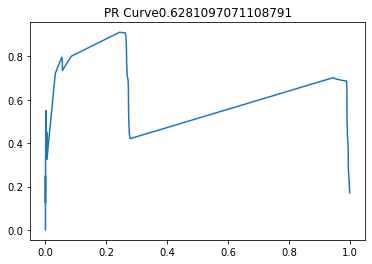

(5836,)
(35020,) (35020,)
AUC : 0.6356 


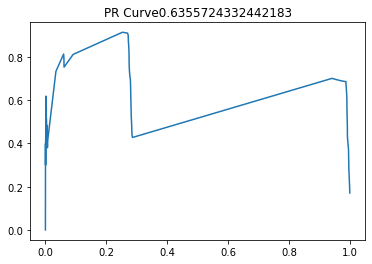

(5836,)
(35020,) (35020,)
AUC : 0.6260 


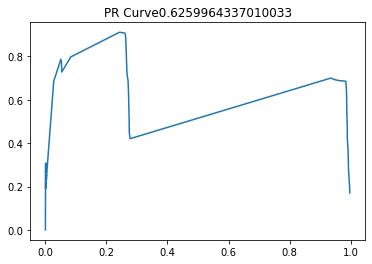

(5836,)
(35020,) (35020,)
AUC : 0.6338 


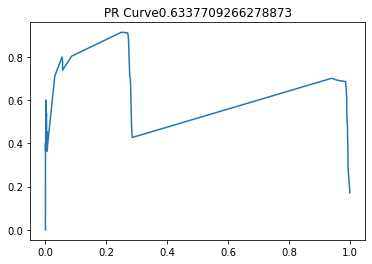

(5836,)
(35020,) (35020,)
AUC : 0.6234 


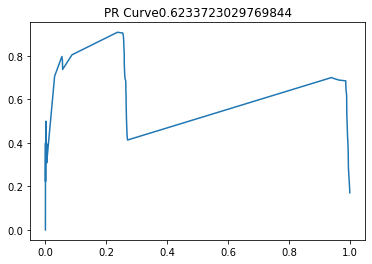

 Mean AUC  0.6293643607321945
 AUC std 0.004621251597701844


In [11]:
test(
    dagmm_obj,
    data_dict
)